## NuMI Analysis: Nue Smearing

#### Get the smearing matix for nue

First, setup.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward
from collections import defaultdict

main_path = ls.main_path
sys.path.append(main_path)

from ROOT import TCanvas, TFile, TProfile, TNtuple, TH1F, TH2F
from ROOT import gROOT, gBenchmark, gRandom, gSystem

import csv

/home/alex/NuMI/PELEE/
Welcome to JupyROOT 6.24/02


In [2]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

In [3]:
params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [4]:
isRun3 = False

#to use both Run1 and Run3
isCombined = True

ending = "Sept19_rebinned"

Now get some data.

In [5]:
import time
s = time.time()

# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
#full sample
if isRun3 == False and isCombined == False:
    NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
elif isRun3 == True and isCombined == False:
    NUE  = '/neutrinoselection_filt_run3b_overlay_intrinsic'+ls.APPEND
elif isCombined == True:
    NUE_R1  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
    NUE_R3  = '/neutrinoselection_filt_run3b_overlay_intrinsic'+ls.APPEND


#actually fetch datasets
if isCombined == False:
    nue_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]
elif isCombined == True:
    nue_nue_r1  = uproot.open(ls.ntuple_path+NUE_R1+".root")[ls.fold][tree]
    nue_nue_r3  = uproot.open(ls.ntuple_path+NUE_R3+".root")[ls.fold][tree]

# Define a list that contains the data sets
if isCombined == False:
    uproot_v = [nue_nue]
elif isCombined == True:
    uproot_v = [nue_nue_r1, nue_nue_r3]    

nue_variables = ["run", "sub", "evt", "swtrig_pre",
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction", "proton_e", "elec_e",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

if isCombined == False:
    nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)
elif isCombined == True:
    nue_nue_r1  = nue_nue_r1.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)
    nue_nue_r3  = nue_nue_r3.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)

    
#just prints out the time this cell takes
s2 = time.time()
print("")
print ("time to run: ",s2-s)
#run1 = approx 3 mins

['nproton', 'shr_phi', 'shr_pz', 'shr_tkfit_nhits_V', 'shr_score', 'shr_theta', 'evt', 'reco_nu_vtx_sce_x', 'trk_score_v', 'n_showers_contained', 'shr_py', 'reco_nu_vtx_sce_y', 'shrsubclusters0', 'topological_score', 'swtrig_pre', 'tksh_distance', 'npi0', 'proton_e', 'reco_nu_vtx_sce_z', 'shr_tkfit_nhits_Y', 'tksh_angle', 'shrsubclusters1', 'slnunhits', 'shrmoliereavg', 'nslice', 'shrsubclusters2', 'shr_energy_tot_cali', 'n_showers', 'trk_energy_tot', 'category', 'CosmicIPAll3D', 'n_tracks_contained', 'run', 'hits_ratio', 'ccnc', 'trk_energy', 'shr_tkfit_npoints', 'trkshrhitdist2', 'sub', 'shr_tkfit_dedx_Y', 'flash_time', 'npion', 'shr_energy_cali', 'shr_energy', 'nu_pdg', 'shr_tkfit_dedx_V', 'slnhits', 'contained_fraction', 'shr_tkfit_dedx_U', 'shr_distance', 'shr_tkfit_nhits_U', 'shr_px', 'selected', 'elec_e', 'n_tracks']

time to run:  267.6760799884796


The following cell allows us to reload original data event weights. No weights have been added to data or ext so these are not included.

In [6]:
if isCombined == False:
    df_v = [nue_nue]
elif isCombined == True:
    df_v = [nue_nue_r1, nue_nue_r3]

In [7]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
#df_v = [nue_nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']
    
#BDT

In [8]:
# Let's calculate the weights that we need to apply to the individual MC events 
# to become our best model of the NuMI data. 
# This cell calculates the GENIE Tune * PPFX correction to the MC weights and 
# cleans up extremely high (or low) weight scores (may be due to computational errors).
# The clean up is not the best practice (one should dig and understand why the weight are big/negative): 
# it's a cheat until we figure out the next best thing. Life is not perfect and your analysis won't be either. Please enojy LArbys

constructNuMISys = True

if isCombined == False:
    df_v = [nue_nue]
elif isCombined == True:
    df_v = [nue_nue_r1, nue_nue_r3]

# We need to do this only for the MC samples (all data events weight = 1)
#df_v = [nue_nue]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

#BDT

Get Log Likelihood Ratio Particle ID for track candidates. Will need proton for nue, muon for numu.

In [9]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [10]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [11]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!

#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
#df_v = [nue_nue]

if isCombined == False:
    df_v = [nue_nue]
elif isCombined == True:
    df_v = [nue_nue_r1, nue_nue_r3]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    #df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

#BDT

time to run:  73.1619484424591


In [12]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [13]:
#df_v = [nue_nue]
if isCombined == False:
    df_v = [nue_nue]
elif isCombined == True:
    df_v = [nue_nue_r1, nue_nue_r3]
    
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']


In [14]:
INTERCEPT = 0.0
SLOPE = 0.83

if isCombined == False:
    df_v = [nue_nue]
elif isCombined == True:
    df_v = [nue_nue_r1, nue_nue_r3]
    
#df_v = [nue_nue]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"]+ df["proton_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])

In [15]:
## add back the cosmic category, for background only
#df_v = [nue_nue]
#for i,df in enumerate(df_v):
#    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    
#BDT    

In [15]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
#df_v = [nue_nue]
if isCombined == False:
    df_v = [nue_nue]
elif isCombined == True:
    df_v = [nue_nue_r1, nue_nue_r3]

for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304    

In [16]:
# Some quick clean up since some strange events get in there
if isCombined == False:
    nue_nue  = nue_nue.query('nu_e > 0.')
    dfmc_v = [nue_nue]
elif isCombined == True:
    nue_nue_r1  = nue_nue_r1.query('nu_e > 0.')
    nue_nue_r3  = nue_nue_r3.query('nu_e > 0.')
    dfmc_v = [nue_nue_r1, nue_nue_r3]

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
#dfmc_v = [nue_nue]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    


## Selection Section

In [18]:

#df_v = [nue_nue]
#for i,df in enumerate(df_v):
#    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
#    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
#    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

## BDT

In [17]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'


In [18]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model_r1 = xgb.Booster({'nthread': 4})
bdt_model_r3 = xgb.Booster({'nthread': 4})

if isRun3 == False and isCombined==False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3 == True and isCombined==False:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model') 
elif isCombined == True:
    bdt_model_r1.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
    bdt_model_r3.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model') 

In [19]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

if isCombined == False:
    datasetlist = [nue_nue]
elif isCombined == True:
    datasetlist = [nue_nue_r1, nue_nue_r3]

count = 0
for df in datasetlist:
    count = count +1
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])

    # apply the bdt selection
    if isCombined==True and count==1:
        preds = bdt_model_r1.predict(df_test)
    elif isCombined==True and count==2:
        preds = bdt_model_r3.predict(df_test)
    else:
        preds = bdt_model.predict(df_test)
        
        
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(127551, 123)
(124396, 123)


In [20]:
#print(nue_nue_r1)

In [21]:
if isCombined == False:
    datasets_bdt = nue_nue
elif isCombined == True:
    datasets_bdt_r1 = nue_nue_r1
    datasets_bdt_r3 = nue_nue_r3

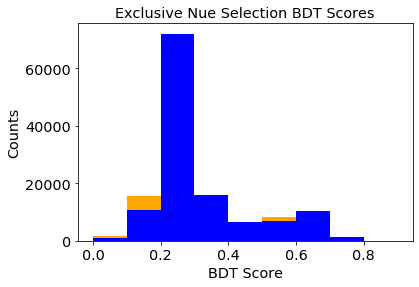

In [22]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt_r1['BDT_score'], bins, color='orange')
gen2 = plt.hist(datasets_bdt_r3['BDT_score'], bins, color='blue')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [23]:
if isCombined == False:
    df_v = [nue_nue]
elif isCombined == True:
    df_v = [nue_nue_r1, nue_nue_r3]
    
for i,df in enumerate(df_v):
    
    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.true_e>1.0) & (df.true_e <4.0) & (df.reco_e>1.0) & (df.reco_e <4.0)
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1
            
        
#OLD
#(df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)

In [24]:
###Need to use the same BDT split value Katerina did

SEL_QUERY = BDT_LOOSE_CUTS
SEL_QUERY += ' and reco_e > 1.0 and reco_e < 4.0'
SEL_QUERY += ' and true_e > 1.0 and true_e < 4.0'

#OLD
#SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#SEL_QUERY += ' and true_e > 0.04 and true_e < 5'

if isCombined == True:
    SEL_QUERY_R1 = SEL_QUERY + ' and BDT_score > 0.55' 
    SEL_QUERY_R3 = SEL_QUERY + ' and BDT_score > 0.575'     

    SIGNAL_NUE_SEL_QUERY_R1 = SEL_QUERY_R1
    SIGNAL_NUE_SEL_QUERY_R1 += 'and is_signal==True'
    SIGNAL_NUE_SEL_QUERY_R3 = SEL_QUERY_R3
    SIGNAL_NUE_SEL_QUERY_R3 += 'and is_signal==True'
else:
    if isRun3 == False:
        SEL_QUERY += ' and BDT_score > 0.55' 
    elif isRun3 == True:
        SEL_QUERY += ' and BDT_score > 0.575'     

    SIGNAL_NUE_SEL_QUERY = SEL_QUERY
    SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

In [25]:
#New categories

for i,df in enumerate(df_v):
            
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1)& (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

## Smearing with Weights test

In [26]:
#TOTAL_QUERY = SIGNAL_NUE_SEL_QUERY

In [27]:
##THE TRUTH
if isCombined == False:
    import batch_plotter_alex
    import importlib
    importlib.reload(batch_plotter_alex)
    scaling = 1

    SPLIT = 1.0

    n_events = nue_nue.shape[0]
    print("n_events here = ", n_events)
    #print("n_events/2 here = ", np.floor(n_events/1.25))
    print("")
    #batch_size = 40000
    batch_size = n_events
    #batch_size = int(np.floor(n_events/1.25))
    #n_events = batch_size

    varss1 = []
    weightss1 = []
    labss1 = []

    print(n_events/batch_size)
    print(int(n_events/batch_size))

    for i in range(int(n_events/batch_size)+1):
        start = i*batch_size
        if (start + batch_size) < n_events:
            end = start + batch_size
        else:
            end = n_events
        sample_set = nue_nue.iloc[start:end]

        samples = {
            #"nue_nue": nue_nue
            "nue_nue": sample_set 
        }


        scaling = 1
        if isRun3 == False:
            pot =  2e+20 
            nueratio  = pot/2.37838e+22 
        elif isRun3 == True:
            pot =  5.014e20
            nueratio  = pot/2.5345e+22

        # NUE
        weights = { #full sample mc = 0.38
                    "nue_nue"  : nueratio  * SPLIT * scaling
        }


        my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
        print(weights)


        #Now check on a variable
        #Remember to change the plotter keys between truth and mc

        VARIABLE, BINS, RANGE, XTIT = 'true_e',6,(1.0, 4.0),"True Energy [GeV]"
        
        #OLD
        #VARIABLE, BINS, RANGE, XTIT = 'true_e',10,(0.0, 5.0),"True Energy [GeV]"


        var1, weight1, label1 = my_plotter.plot_variable(
            VARIABLE,
            query= TOTAL_QUERY,
            currentsample = "nue_nue",
            kind="event_category",
            draw_sys  = True, 
            draw_geoSys = True, 
            draw_data = True,
            ratio=False,
            genieweight = "weightSplineTimesTuneTimesPPFX",  
            stacksort=3,
            title=XTIT,
            bins=BINS,
            range=RANGE
        )[0:3]

        varss1.append(var1)
        weightss1.append(weight1)
        labss1.append(label1)

n_events here =  127551
n_events/2 here =  102040.0

1.0
1
{'nue_nue': 0.008409085175623745}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 1.0 and reco_e < 4.0 and true_e > 1.0 and true_e < 4.0 and BDT_score > 0.55and is_signal==True& true_e <= 4 & true_e >= 1 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_nue
--------------------------------------
current sample is:  nue_nue
[1.2228513  1.1611798  1.1281003  ... 0.5484056  1.2914385  0.61497796]
current_total  16.847972445189576
16.847972445189576262691844021901488304138183593750000000000000000000000000000
---------------------------STILL TOGETHER HERE

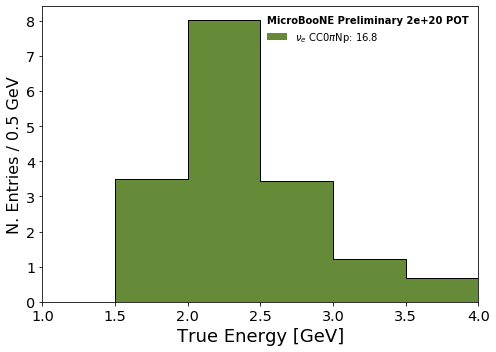

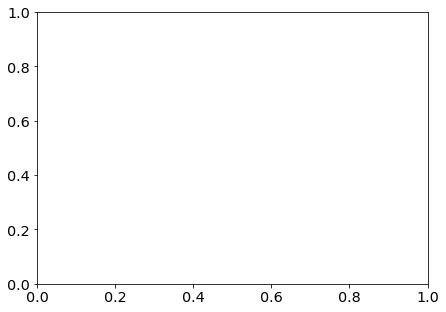

In [28]:
if isCombined == True:
    import batch_plotter_alex
    import importlib
    importlib.reload(batch_plotter_alex)
    scaling = 1

    SPLIT = 1.0

    n_events = nue_nue_r1.shape[0]
    print("n_events here = ", n_events)
    print("n_events/2 here = ", np.floor(n_events/1.25))
    print("")
    #batch_size = 40000
    batch_size = n_events
    #batch_size = int(np.floor(n_events/1.25))
    #n_events = batch_size

    varss1 = []
    weightss1 = []
    labss1 = []

    print(n_events/batch_size)
    print(int(n_events/batch_size))

    for i in range(int(n_events/batch_size)+1):
        start = i*batch_size
        if (start + batch_size) < n_events:
            end = start + batch_size
        else:
            end = n_events
        sample_set = nue_nue_r1.iloc[start:end]

        samples = {
            #"nue_nue": nue_nue
            "nue_nue": sample_set 
        }


        scaling = 1
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 

        # NUE
        weights = { #full sample mc = 0.38
                    "nue_nue"  : nueratio  * SPLIT * scaling
        }


        my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
        print(weights)


        #Now check on a variable
        #Remember to change the plotter keys between truth and mc

        VARIABLE, BINS, RANGE, XTIT = 'true_e', 6,(1.0, 4.0),"True Energy [GeV]"
        
        #OLD
        #VARIABLE, BINS, RANGE, XTIT = 'true_e', 10,(0.0, 5.0),"True Energy [GeV]"


        var1, weight1, label1 = my_plotter.plot_variable(
            VARIABLE,
            query= SIGNAL_NUE_SEL_QUERY_R1,
            currentsample = "nue_nue",
            kind="event_category",
            draw_sys  = True, 
            draw_geoSys = True, 
            draw_data = True,
            ratio=False,
            genieweight = "weightSplineTimesTuneTimesPPFX",  
            stacksort=3,
            title=XTIT,
            bins=BINS,
            range=RANGE
        )[0:3]

        varss1.append(var1)
        weightss1.append(weight1)
        labss1.append(label1)

n_events here =  124396

1.0
1
{'nue_nue': 0.01978299467350562}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 1.0 and reco_e < 4.0 and true_e > 1.0 and true_e < 4.0 and BDT_score > 0.575and is_signal==True& true_e <= 4 & true_e >= 1 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_nue
--------------------------------------
current sample is:  nue_nue
[1.1240371  1.0383462  0.845366   ... 1.0834242  0.844318   0.83344865]
current_total  35.01961278396699
35.019612783966991287343262229114770889282226562500000000000000000000000000000
---------------------------STILL TOGETHER HERE-----------------------------

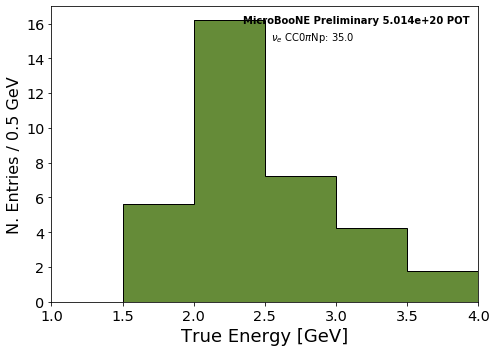

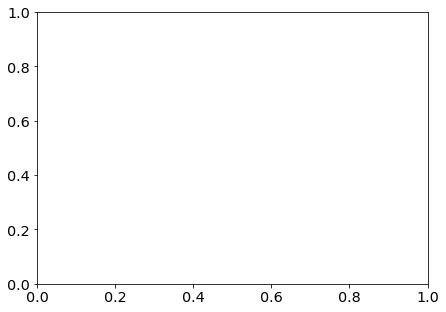

In [29]:
if isCombined == True:
    import batch_plotter_alex
    import importlib
    importlib.reload(batch_plotter_alex)
    scaling = 1

    SPLIT = 1.0

    n_events = nue_nue_r3.shape[0]
    print("n_events here = ", n_events)
    print("")
    #batch_size = 40000
    batch_size = n_events
    #batch_size = int(np.floor(n_events/1.25))
    #n_events = batch_size

    varss1b = []
    weightss1b = []
    labss1b = []

    print(n_events/batch_size)
    print(int(n_events/batch_size))

    for i in range(int(n_events/batch_size)+1):
        start = i*batch_size
        if (start + batch_size) < n_events:
            end = start + batch_size
        else:
            end = n_events
        sample_set = nue_nue_r3.iloc[start:end]

        samples = {
            #"nue_nue": nue_nue
            "nue_nue": sample_set 
        }


        scaling = 1
        pot =  5.014e20
        nueratio  = pot/2.5345e+22

        # NUE
        weights = { #full sample mc = 0.38
                    "nue_nue"  : nueratio  * SPLIT * scaling
        }


        my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
        print(weights)


        #Now check on a variable
        #Remember to change the plotter keys between truth and mc

        VARIABLE, BINS, RANGE, XTIT = 'true_e',6,(1.0, 4.0),"True Energy [GeV]"
        
        #OLD
        #VARIABLE, BINS, RANGE, XTIT = 'true_e',10,(0.0, 5.0),"True Energy [GeV]"


        var1, weight1, label1 = my_plotter.plot_variable(
            VARIABLE,
            query= SIGNAL_NUE_SEL_QUERY_R3,
            currentsample = "nue_nue",
            kind="event_category",
            draw_sys  = True, 
            draw_geoSys = True, 
            draw_data = True,
            ratio=False,
            genieweight = "weightSplineTimesTuneTimesPPFX",  
            stacksort=3,
            title=XTIT,
            bins=BINS,
            range=RANGE
        )[0:3]

        varss1b.append(var1)
        weightss1b.append(weight1)
        labss1b.append(label1)

No handles with labels found to put in legend.


(array([0.        , 3.49936025, 8.01168971, 3.43349941, 1.23151749,
       0.67190558]), array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ], dtype=float32), <a list of 6 Patch objects>)
(array([0., 0., 0., 0., 0., 0.]), array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ]), <a list of 6 Patch objects>)


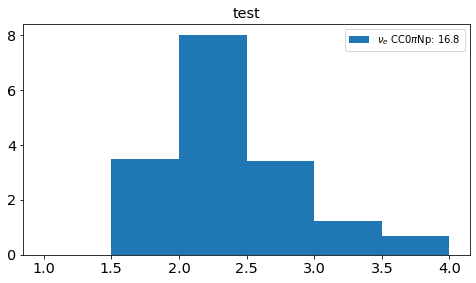

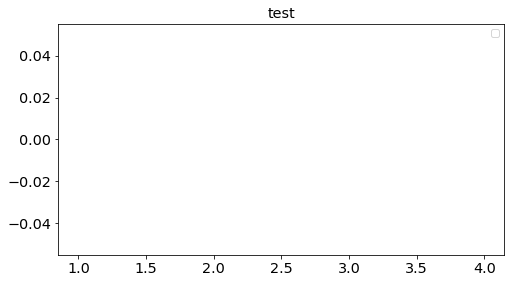

In [30]:

from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss1[i].values(),
                weights=list(weightss1[i].values()),
                stacked=True,
                label=labss1[i],
                bins=BINS,
                range=RANGE)

    plt.title("test")
    plt.legend()

    print(nue_stacked)
    #temp_truth_sig = nue_stacked[0]
    #print(temp_truth_sig)

No handles with labels found to put in legend.


(array([ 0.        ,  5.5999867 , 16.17774074,  7.22288467,  4.23347334,
        1.78552734]), array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ], dtype=float32), <a list of 6 Patch objects>)
(array([0., 0., 0., 0., 0., 0.]), array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ]), <a list of 6 Patch objects>)


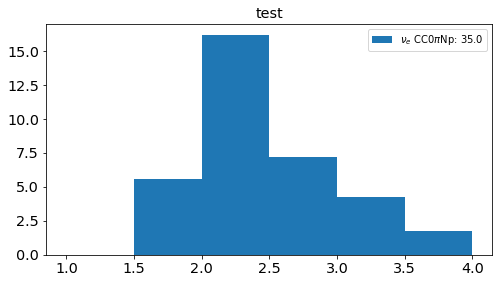

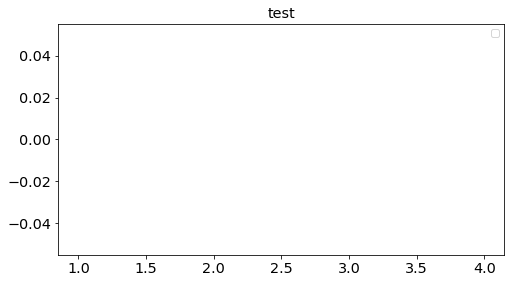

In [34]:
if isCombined == True:
    from matplotlib import gridspec

    for i in range(int(n_events/batch_size)+1):
        nue_fig = plt.figure(figsize=(8, 7))
        nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
        nue_ax1 = plt.subplot(nue_gs[0])
        #nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
        #nue_ax1.set_xlim([-1, 1])    #AngleDiff

        nue_stacked = nue_ax1.hist(
                    varss1b[i].values(),
                    weights=list(weightss1b[i].values()),
                    stacked=True,
                    label=labss1b[i],
                    bins=BINS,
                    range=RANGE)

        plt.title("test")
        plt.legend()

        print(nue_stacked)
        #temp_truth_sig = nue_stacked[0]
        #print(temp_truth_sig)

0.0


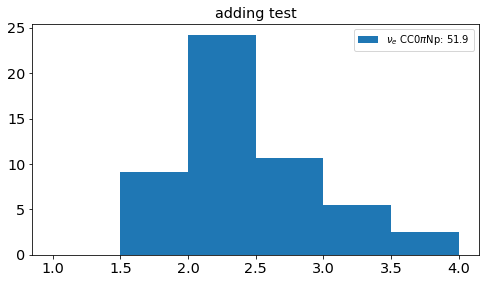

In [32]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    

if isCombined == False:
    varss_tot = combine_dicts(varss1)
    weightss_tot = combine_dicts(weightss1)
elif isCombined == True:
    varss_temp = varss1 + varss1b
    weightss_temp = weightss1 + weightss1b
    varss_tot = combine_dicts(varss_temp)
    weightss_tot = combine_dicts(weightss_temp)

category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}



labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss1[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
#nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 160])
#nue_ax1.set_ylim([0, 40])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 180])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

print(nue_stacked[0][0])

temp_truth_sig = nue_stacked[0][0]
#print('%.50f' % math.fsum(temp_truth_sig))

In [33]:
signal_nue_selected = temp_truth_sig
print("signal_nue_selected ", signal_nue_selected)

signal_nue_selected  0.0


In [ ]:
################################################################################

In [35]:
# NOW WITH RECO SELECTION

if isCombined == False:
    import batch_plotter_alex
    import importlib
    importlib.reload(batch_plotter_alex)
    scaling = 1

    SPLIT = 1.0

    n_events = nue_nue.shape[0]
    print("n_events here = ", n_events)
    print("n_events/2 here = ", np.floor(n_events/1.25))
    print("")
    #batch_size = 40000
    batch_size = n_events
    #batch_size = int(np.floor(n_events/1.25))
    #n_events = batch_size

    varss2 = []
    weightss2 = []
    labss2 = []

    print(n_events/batch_size)
    print(int(n_events/batch_size))

    for i in range(int(n_events/batch_size)+1):
        start = i*batch_size
        if (start + batch_size) < n_events:
            end = start + batch_size
        else:
            end = n_events
        sample_set = nue_nue.iloc[start:end]

        samples = {
            #"nue_nue": nue_nue
            "nue_nue": sample_set 
        }


        scaling = 1
        if isRun3 == False:
            pot =  2e+20 
            nueratio  = pot/2.37838e+22 
        elif isRun3 == True:
            pot =  5.014e20
            nueratio  = pot/2.5345e+22

        # NUE
        weights = { #full sample mc = 0.38
                    "nue_nue"  : nueratio  * SPLIT * scaling
        }


        my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
        print(weights)


        #Now check on a variable
        #Remember to change the plotter keys between truth and mc

        VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(1.0, 4.0),"Reconstructed Energy [GeV]"
        
        #OLD
        #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"


        var2, weight2, label2 = my_plotter.plot_variable(
            VARIABLE,
            query= TOTAL_QUERY,
            currentsample = "nue_nue",
            kind="event_category",
            draw_sys  = True, 
            draw_geoSys = True, 
            draw_data = True,
            ratio=False,
            genieweight = "weightSplineTimesTuneTimesPPFX",  
            stacksort=3,
            title=XTIT,
            bins=BINS,
            range=RANGE
        )[0:3]

        varss2.append(var2)
        weightss2.append(weight2)
        labss2.append(label2)

n_events here =  127551
n_events/2 here =  102040.0

1.0
1
{'nue_nue': 0.008409085175623745}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 1.0 and reco_e < 4.0 and true_e > 1.0 and true_e < 4.0 and BDT_score > 0.55and is_signal==True& reco_e <= 4 & reco_e >= 1 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_nue
--------------------------------------
current sample is:  nue_nue
[1.2228513  1.1611798  1.1281003  ... 0.5484056  1.2914385  0.61497796]
current_total  16.847972445189576
16.847972445189576262691844021901488304138183593750000000000000000000000000000
---------------------------STILL TOGETHER HERE

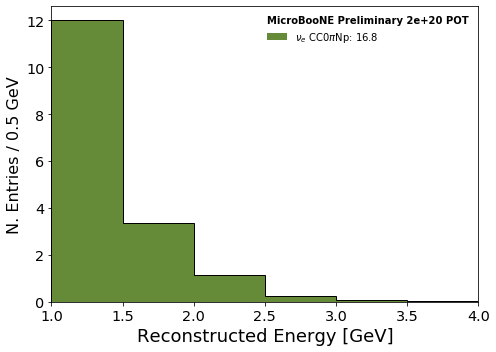

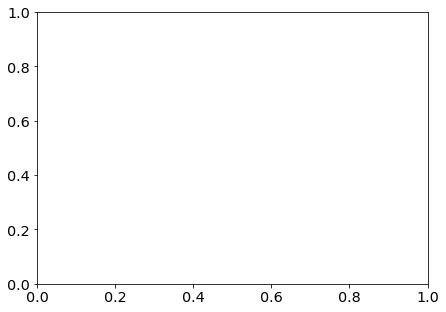

In [36]:
if isCombined == True:
    import batch_plotter_alex
    import importlib
    importlib.reload(batch_plotter_alex)
    scaling = 1

    SPLIT = 1.0

    n_events = nue_nue_r1.shape[0]
    print("n_events here = ", n_events)
    print("n_events/2 here = ", np.floor(n_events/1.25))
    print("")
    #batch_size = 40000
    batch_size = n_events
    #batch_size = int(np.floor(n_events/1.25))
    #n_events = batch_size

    varss2 = []
    weightss2 = []
    labss2 = []

    print(n_events/batch_size)
    print(int(n_events/batch_size))

    for i in range(int(n_events/batch_size)+1):
        start = i*batch_size
        if (start + batch_size) < n_events:
            end = start + batch_size
        else:
            end = n_events
        sample_set = nue_nue_r1.iloc[start:end]

        samples = {
            #"nue_nue": nue_nue
            "nue_nue": sample_set 
        }


        scaling = 1
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 

        # NUE
        weights = { #full sample mc = 0.38
                    "nue_nue"  : nueratio  * SPLIT * scaling
        }


        my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
        print(weights)


        #Now check on a variable
        #Remember to change the plotter keys between truth and mc

        VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(1.0, 4.0),"Reconstructed Energy [GeV]"
        
        #OLD
        #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"


        var2, weight2, label2 = my_plotter.plot_variable(
            VARIABLE,
            query= SIGNAL_NUE_SEL_QUERY_R1,
            currentsample = "nue_nue",
            kind="event_category",
            draw_sys  = True, 
            draw_geoSys = True, 
            draw_data = True,
            ratio=False,
            genieweight = "weightSplineTimesTuneTimesPPFX",  
            stacksort=3,
            title=XTIT,
            bins=BINS,
            range=RANGE
        )[0:3]

        varss2.append(var2)
        weightss2.append(weight2)
        labss2.append(label2)

n_events here =  124396
n_events/2 here =  99516.0

1.0
1
{'nue_nue': 0.01978299467350562}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 1.0 and reco_e < 4.0 and true_e > 1.0 and true_e < 4.0 and BDT_score > 0.575and is_signal==True& reco_e <= 4 & reco_e >= 1 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_nue
--------------------------------------
current sample is:  nue_nue
[1.1240371  1.0383462  0.845366   ... 1.0834242  0.844318   0.83344865]
current_total  35.01961278396699
35.019612783966991287343262229114770889282226562500000000000000000000000000000
---------------------------STILL TOGETHER HERE--

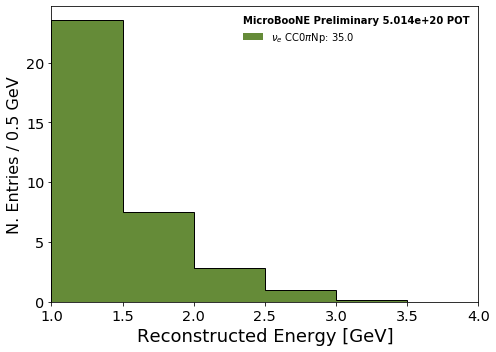

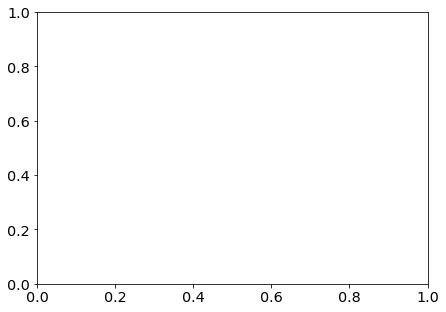

In [37]:
if isCombined == True:
    import batch_plotter_alex
    import importlib
    importlib.reload(batch_plotter_alex)
    scaling = 1

    SPLIT = 1.0

    n_events = nue_nue_r3.shape[0]
    print("n_events here = ", n_events)
    print("n_events/2 here = ", np.floor(n_events/1.25))
    print("")
    #batch_size = 40000
    batch_size = n_events
    #batch_size = int(np.floor(n_events/1.25))
    #n_events = batch_size

    varss2b = []
    weightss2b = []
    labss2b = []

    print(n_events/batch_size)
    print(int(n_events/batch_size))

    for i in range(int(n_events/batch_size)+1):
        start = i*batch_size
        if (start + batch_size) < n_events:
            end = start + batch_size
        else:
            end = n_events
        sample_set = nue_nue_r3.iloc[start:end]

        samples = {
            #"nue_nue": nue_nue
            "nue_nue": sample_set 
        }


        scaling = 1
        pot =  5.014e20
        nueratio  = pot/2.5345e+22

        # NUE
        weights = { #full sample mc = 0.38
                    "nue_nue"  : nueratio  * SPLIT * scaling
        }


        my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
        print(weights)


        #Now check on a variable
        #Remember to change the plotter keys between truth and mc

        VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(1.0, 4.0),"Reconstructed Energy [GeV]"
        
        #OLD
        #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"


        var2, weight2, label2 = my_plotter.plot_variable(
            VARIABLE,
            query= SIGNAL_NUE_SEL_QUERY_R3,
            currentsample = "nue_nue",
            kind="event_category",
            draw_sys  = True, 
            draw_geoSys = True, 
            draw_data = True,
            ratio=False,
            genieweight = "weightSplineTimesTuneTimesPPFX",  
            stacksort=3,
            title=XTIT,
            bins=BINS,
            range=RANGE
        )[0:3]

        varss2b.append(var2)
        weightss2b.append(weight2)
        labss2b.append(label2)

No handles with labels found to put in legend.


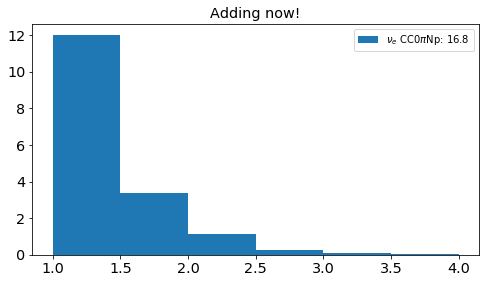

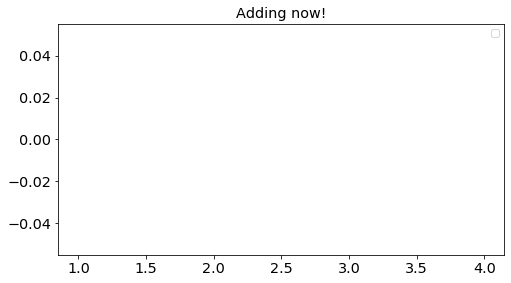

In [38]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss2[i].values(),
                weights=list(weightss2[i].values()),
                stacked=True,
                label=labss2[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()
    
    #print('%.50f' % math.fsum(nue_stacked[0]))
    
    #print(56.99571519411813/56.99561667442322)
    #print(56.9957151941182/56.99562072753906)

No handles with labels found to put in legend.


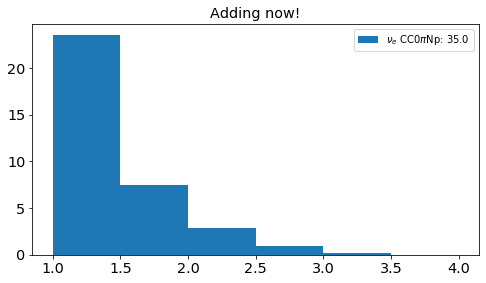

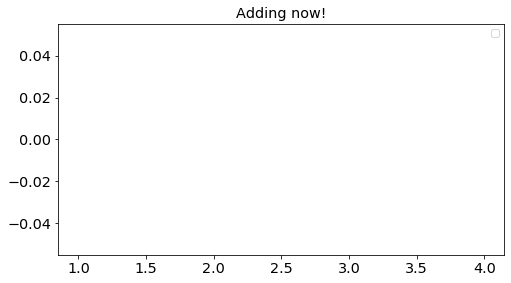

In [39]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss2b[i].values(),
                weights=list(weightss2b[i].values()),
                stacked=True,
                label=labss2b[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()
    
    #print('%.50f' % math.fsum(nue_stacked[0]))
    

35.51782610897373


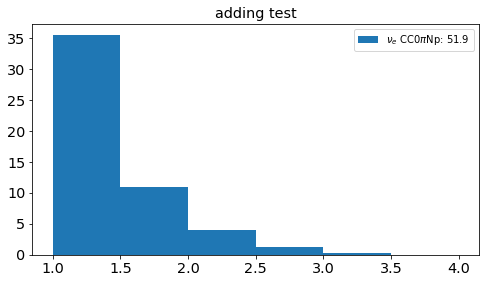

In [40]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    

if isCombined == False:
    varss_tot = combine_dicts(varss2)
    weightss_tot = combine_dicts(weightss2)
elif isCombined == True:
    varss_temp = varss2 + varss2b
    weightss_temp = weightss2 + weightss2b
    varss_tot = combine_dicts(varss_temp)
    weightss_tot = combine_dicts(weightss_temp)

category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}



labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss1[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
#nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 160])
#nue_ax1.set_ylim([0, 40])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 180])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

print(nue_stacked[0][0])

temp_truth_sig = nue_stacked[0][0]

In [41]:
# plot the smearing matrix 
def plot_smearing(var1, var2, weight1, weight2, var3, weight3, bins, norm=False): 
    fig = plt.figure(figsize=(10, 6))
    
    smear = plt.hist2d(var1, var2,
                   bins, weights=weight1, cmin=0.000000001, cmap='OrRd')
    
    sel1 = plt.hist(var1, bins, weights=weight1, color='white')
    print("sel1 = ", sel1[0])
    print("sum sel1 = ", math.fsum(sel1[0]))
    print("")
    sel2 = plt.hist(var2, bins, weights=weight2, color='white')
    print("sel2 = ", sel2[0])
    print("sum sel2 = ", math.fsum(sel2[0]))
    print("")
    print("truth - reco (sel1 - sel2) ")
    print(sel1[0] - sel2[0])
    print(math.fsum(sel1[0]) - math.fsum(sel2[0]))
    
    zero_copy_smear = np.copy(smear[0].T)
    
    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if np.isnan(zero_copy_smear[i,j]):
                zero_copy_smear[i,j]= 0

    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if smear[0].T[i,j] > 0: 
                if smear[0].T[i,j]>80: 
                    col='white'
                else: 
                    col='black'
                    
                binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                        
                plt.text(binx_centers, biny_centers, round(smear[0].T[i,j], 1), 
                    color=col, ha="center", va="center", fontsize=12)

    cbar = plt.colorbar()
    cbar.set_label('Selected Signal Events', fontsize=15)
        
    print("---------------------------------------------------------")

    if norm: 
        plt.close()
        
        norm_array = smear[0].T
        
        gen = plt.hist(var3, bins, weights=weight3, color='deepskyblue')
        print("")
        print("GENERATED")
        print(gen[0])
        print("")
        plt.close()
    
        # for each truth bin (column): 
        for j in range(len(bins)-1): 
        
            #reco_events_in_column = [ norm_array[i][j] for i in range(len(bins)-1) ]
            #tot_reco_events = np.nansum(reco_events_in_column)
        
            # replace with normalized value 
            for i in range(len(bins)-1):
                norm_array[i][j] =  norm_array[i][j] / gen[0][j]
    
        # now plot
        fig = plt.figure(figsize=(10, 6))
        plt.pcolor(bins, bins, norm_array, cmap='OrRd', vmax=1)
        
        zero_copy_smear_norm = np.copy(norm_array)

        for i in range(len(bins)-1): # reco bins i (y axis) rows
            for j in range(len(bins)-1): # true bins j (x axis) cols
                if np.isnan(zero_copy_smear_norm[i,j]):
                    zero_copy_smear_norm[i,j]= 0

        # Loop over data dimensions and create text annotations.
        for i in range(len(bins)-1): # reco bins (rows)
            for j in range(len(bins)-1): # truth bins (cols)
                if norm_array[i][j]>0: 
                
                    if norm_array[i][j]>0.7: 
                        col = 'white'
                    else: 
                        col = 'black'
                    
                    binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                    biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                
                    plt.text(binx_centers, biny_centers, round(norm_array[i][j], 2), 
                         ha="center", va="center", color=col, fontsize=12)
      
        cbar = plt.colorbar()
        cbar.set_label('Fraction of Reco Events in True Bin', fontsize=15)
        
        if isRun3==False and isCombined == False:
            print("isRun3==False and isCombined == False")
            #WHOOPS, overwrote 3dp if needed again....
            np.savetxt("nue_full_500_catsel_nopions_recoE_usingSelection_smearcept_weighted_recoCut_"+ending+".csv", 
               zero_copy_smear_norm,
               delimiter =", ", 
               fmt ='% s')
            print("ZERO COPY SMEAR NORM")
            print(zero_copy_smear_norm)


            with open('nue_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal_recoCut_'+ending+'.csv') as file:
                content = file.readlines()
            prior_true = content[0:]

            for i in range(10):
                prior_true[i]=prior_true[i].rstrip().rstrip(',')
                prior_true[i] = float(prior_true[i])

            print("Prior Truth: ")
            print(prior_true)
            print('%.75f' % prior_true[2])
            print("")

            with open('nue_full_500_catsel_nopions_recoE_usingSelection_data_signal_MCONLY_recoCut_'+ending+'.csv') as file:
                content = file.readlines()
            mcsig = content[0:]

            for i in range(10):
                mcsig[i]=mcsig[i].rstrip().rstrip(',')
                mcsig[i] = float(mcsig[i])

            print("")

            print("SMEAR x PRIOR_TRUE")
            made_data_sig = np.dot(zero_copy_smear_norm, prior_true)
            print(made_data_sig)
            print(sum(made_data_sig))
            print("")
            print("MC DATA SIGNAL")
            print(mcsig)
            print(sum(mcsig))
            print("")
            print("DIFFERENCES")
            diffs = made_data_sig - mcsig

            for i in range(10):
                print(diffs[i])

            #print(diffs)
        elif isRun3==True and isCombined == False:
            print("isRun3==True and isCombined == False")
            np.savetxt("nue_full_500_catsel_nopions_recoE_usingSelection_smearcept_weighted_recoCut_run3_"+ending+".csv", 
               zero_copy_smear_norm,
               delimiter =", ", 
               fmt ='% s')
            print("ZERO COPY SMEAR NORM")
            print(zero_copy_smear_norm)
            """

            with open('nue_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal_recoCut_run3_'+ending+'.csv') as file:
                content = file.readlines()
            prior_true = content[0:]

            for i in range(10):
                prior_true[i]=prior_true[i].rstrip().rstrip(',')
                prior_true[i] = float(prior_true[i])

            print("Prior Truth: ")
            print(prior_true)
            print('%.75f' % prior_true[2])
            print("")

            with open('nue_full_500_catsel_nopions_recoE_usingSelection_data_signal_MCONLY_recoCut_run3_'+ending+'.csv') as file:
                content = file.readlines()
            mcsig = content[0:]

            for i in range(10):
                mcsig[i]=mcsig[i].rstrip().rstrip(',')
                mcsig[i] = float(mcsig[i])

            print("")

            print("SMEAR x PRIOR_TRUE")
            made_data_sig = np.dot(zero_copy_smear_norm, prior_true)
            print(made_data_sig)
            print(sum(made_data_sig))
            print("")
            print("MC DATA SIGNAL")
            print(mcsig)
            print(sum(mcsig))
            print("")
            print("DIFFERENCES")
            diffs = made_data_sig - mcsig

            for i in range(10):
                print(diffs[i])
            """
            #print(diffs)

        elif isCombined == True:
            np.savetxt("nue_full_500_catsel_nopions_recoE_usingSelection_smearcept_weighted_recoCut_comb_"+ending+".csv", 
               zero_copy_smear_norm,
               delimiter =", ", 
               fmt ='% s')
            print("ZERO COPY SMEAR NORM")
            print(zero_copy_smear_norm)

            
            with open('nue_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal_recoCut_comb_'+ending+'.csv') as file:
                content = file.readlines()
            prior_true = content[0:]

            for i in range(10):
                prior_true[i]=prior_true[i].rstrip().rstrip(',')
                prior_true[i] = float(prior_true[i])

            print("Prior Truth: ")
            print(prior_true)
            print('%.75f' % prior_true[2])
            print("")

            with open('nue_full_500_catsel_nopions_recoE_usingSelection_data_signal_MCONLY_recoCut_comb_'+ending+'.csv') as file:
                content = file.readlines()
            mcsig = content[0:]

            for i in range(10):
                mcsig[i]=mcsig[i].rstrip().rstrip(',')
                mcsig[i] = float(mcsig[i])

            print("")

            print("SMEAR x PRIOR_TRUE")
            made_data_sig = np.dot(zero_copy_smear_norm, prior_true)
            print(made_data_sig)
            print(sum(made_data_sig))
            print("")
            print("MC DATA SIGNAL")
            print(mcsig)
            print(sum(mcsig))
            print("")
            print("DIFFERENCES")
            diffs = made_data_sig - mcsig

            for i in range(10):
                print(diffs[i])

            #print(diffs)
            
        
        
    plt.xlabel('True ν Energy [GeV]', fontsize=15)
    plt.ylabel('Reco ν Energy [GeV]', fontsize=15)
    #plt.text(0.1, 4.8, r'MicroBooNE In Progress', fontweight='bold')
    
    plt.show()
    fig.savefig("nue_full_500_catsel_nopions_recoE_usingSelection_smearcept_weighted_recoCut_comb_"+ending+".svg",bbox_inches='tight' )
    
    if norm:
        return zero_copy_smear_norm
    else:
        return zero_copy_smear

In [42]:
def _selection(variable, sample, query="selected==1", extra_cut=None, track_cuts=None, select_longest=True):
        '''
        variable,  must be specified
        select_longest, True by default, keeps from multiple tracks of same event making it through
        query must be a string defining event-level cuts
        track_cuts is a list of cuts of which each entry looks like
            (variable_tobe_cut_on, '>'or'<'or'=='etc, cut value )
            or
            (variable, [operator1, operator2], [cutval1, cutval2]) to do an 'or' cut
        track_
        returns an Series of values that pass all track_cuts
        '''
        sel_query = query
        if extra_cut is not None:
            sel_query += "& %s" % extra_cut
        '''
        if ( (track_cuts == None) or (select_longest == False) ):
            return sample.query(sel_query).eval(variable).ravel()
        '''


        '''
        df = sample.query(sel_query)
        #print (df.isna().sum())
        dfna = df.isna()
        for (colname,colvals) in dfna.iteritems():
            if (colvals.sum() != 0):
                print ('name : ',colname)
                print ('nan entries : ',colvals.sum())
        '''  
        df = sample.query(sel_query)
        
        #if (track_cuts != None):
        #    df = sample.query(sel_query).dropna().copy() #don't want to eliminate anything from memory

        #df = sample.query(sel_query).dropna().copy() #don't want to eliminate anything from memory

        track_cuts_mask = None #df['trk_score_v'].apply(lambda x: x == x) #all-True mask, assuming trk_score_v is available
        if track_cuts is not None:
            vars, track_cuts_mask = _apply_track_cuts(df,variable,track_cuts,track_cuts_mask)
        else:
            vars = df[variable]
        #vars is now a Series object that passes all the cuts
        #select longest of the cut passing tracks
        #assuming all track-level variables end in _v
        if variable[-2:] == "_v" and select_longest:
            vars, longest_mask = _select_longest(df, vars, track_cuts_mask)
        elif "_v_" in variable:
            print("Variable is being interpretted as event-level, not track_level, despite having _v in name")
            print("the longest track is NOT being selected")
        return vars.ravel()
    
#-------------------------------------------------------------------
def _apply_track_cuts(df,variable,track_cuts,mask):
    '''
    df is dataframe of the sample of interest
    variable is what values will be in the output
    track_cuts are list of tuples defining track_cuts
    input mask to be built upon

    returns
        Series of values of variable that pass all track_cuts
        boolean mask that represents union of input mask and new cut mask
    '''
    #need to do this fancy business with the apply function to make masks
    #this is because unflattened DataFrames are used
    for (var,op,val) in track_cuts:
        if type(op) == list:
            #this means treat two conditions in an 'or' fashion
            or_mask1 = df[var].apply(lambda x: eval("x{}{}".format(op[0],val[0])))#or condition 1
            or_mask2 = df[var].apply(lambda x: eval("x{}{}".format(op[1],val[1])))#or condition 2
            mask *= (or_mask1 + or_mask2) #just add the booleans for "or"
        else:
            mask *= df[var].apply(lambda x: eval("x{}{}".format(op,val))) #layer on each cut mask
    vars = (df[variable]*mask).apply(lambda x: x[x != False]) #apply mask
    vars = vars[vars.apply(lambda x: len(x) > 0)] #clean up empty slices
    #fix list comprehension issue for non '_v' variables
    if variable[-2:] != "_v":
        vars = vars.apply(lambda x: x[0])
    elif "_v" not in variable:
        print("_v not found in variable, assuming event-level")
        print("not fixing list comprehension bug for this variable")

    return vars, mask
    
#-----------------------------------------------------------------------

def _select_longest(df, variable, mask):
    '''
    df: dataframe for sample
    variable: Series of values that pass cuts defined by mask
    mask: mask used to find variable

    returns
        list of values of variable corresponding to longest track in each slices
        boolean mask for longest tracks in df
    '''

    #print("selecting longest...")
    #print("mask", mask)
    trk_lens = (df['trk_len_v']*mask).apply(lambda x: x[x != False])#apply mask to track lengths
    trk_lens = trk_lens[trk_lens.apply(lambda x: len(x) > 0)]#clean up slices
    variable = variable.apply(lambda x: x[~np.isnan(x)])#clean up nan vals
    variable = variable[variable.apply(lambda x: len(x) > 0)] #clean up empty slices
    nan_mask = variable.apply(lambda x: np.nan in x or "nan" in x)
    longest_mask = trk_lens.apply(lambda x: x == x[list(x).index(max(x))])#identify longest
    variable = (variable*longest_mask).apply(lambda x: x[x!=False])#apply mask
    if len(variable.iloc[0]) == 1:
        variable = variable.apply(lambda x: x[0] if len(x)>0 else -999)#expect values, not lists, for each event
    else:
        if len(variable.iloc[0]) == 0:
            raise ValueError(
                "There is no longest track per slice")
        elif len(variable.iloc[0]) > 1:
            #this happens with the reco_nu_e_range_v with unreconstructed values
            print("there are more than one longest slice")
            print(variable.iloc[0])
            try:
                variable = variable.apply(lambda x: x[0])
            except:
                raise ValueError(
                    "There is more than one longest track per slice in \n var {} lens {}".format(variable,trk_lens))

    return variable, longest_mask
    
#-----------------------------------------------------------------------
def _get_genie_weight(sample, variable, query="selected==1", extra_cut=None, track_cuts=None,\
                          select_longest=True, weightvar="weightSplineTimesTuneTimesPPFX",weightsignal=None):

        plotted_variable = _selection(
            variable, sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
        genie_weights = _selection(
            weightvar, sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
        if (weightsignal != None):
            genie_weights *= _selection(
            weightsignal, sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
        if plotted_variable.size > 0:
            if isinstance(plotted_variable[0], np.ndarray):
                if "trk" in variable or select_longest:
                    score = self._selection(
                        "trk_score_v", sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
                else:
                    score = self._selection(
                        "shr_score_v", sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
                genie_weights = np.array([
                    np.array([c] * len(v[s > 0.5])) for c, v, s in zip(genie_weights, plotted_variable, score)
                ])
                genie_weights = np.hstack(genie_weights)
        return genie_weights
    
    

In [43]:
if isCombined == False:
    n_events = nue_nue.shape[0]
    print("n_events here = ", n_events)
    #print("n_events/2 here = ", np.floor(n_events/2))
    print("")
    batch_size = n_events
    #batch_size = int(np.floor(n_events/5))
    #n_events = batch_size

    varss = []
    weightss = []
    labss = []

    print(n_events/batch_size)
    print(int(n_events/batch_size))


    start = 0*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    #sample_set = nue_nue

    #samples = {
        #"nue_nue": nue_nue
     #   "nue_nue": sample_set 
    #}


    current_genie_weights = _get_genie_weight(
                    sample_set, 'true_e', query=TOTAL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")


    current_genie_weights2 = _get_genie_weight(
                    sample_set, 'reco_e', query=TOTAL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")


    current_genie_weights3 = _get_genie_weight(
                    sample_set, 'true_e', query="is_signal == True", track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

    test_list1 = current_genie_weights
    test_list2 = current_genie_weights2

    if len(test_list1) == len(test_list2) and len(test_list1) == sum([1 for i, j in zip(test_list1, test_list2) if i == j]):
        print("All is well.")
    else:
        print("Oh no.")

        
    bins = np.arange(1.0, 4.5, 0.5)
    #OLD 
    #bins = np.arange(0.0, 5.5, 0.5)

    var1 = sample_set.query(TOTAL_QUERY)['true_e']
    weight1 = current_genie_weights * weights["nue_nue"]
    if isRun3 == False and isCombined == False:
        var1.to_csv("nue_full_var1_recoCut_"+ending+".csv")
        np.savetxt("nue_full_weight1_recoCut_"+ending+".csv", 
                    weight1,
                    delimiter =", ", 
                    fmt ='% s')
    if isRun3 == True and isCombined == False:
        var1.to_csv("nue_full_var1_recoCut_run3_"+ending+".csv")
        np.savetxt("nue_full_weights1_recoCut_run3_"+ending+".csv", 
                    weight1,
                    delimiter =", ", 
                    fmt ='% s')
    

    var2 = sample_set.query(TOTAL_QUERY)['reco_e']
    weight2 = current_genie_weights2* weights["nue_nue"]
    if isRun3 == False and isCombined == False:
        var2.to_csv("nue_full_var2_recoCut_"+ending+".csv")
        np.savetxt("nue_full_weight2_recoCut_"+ending+".csv", 
                    weight2,
                    delimiter =", ", 
                    fmt ='% s')
    if isRun3 == True and isCombined == False:
        var2.to_csv("nue_full_var2_recoCut_run3_"+ending+".csv")
        np.savetxt("nue_full_weights2_recoCut_run3_"+ending+".csv", 
                    weight2,
                    delimiter =", ", 
                    fmt ='% s')


    var3 = sample_set.query("is_signal == True")['true_e']
    weight3 = current_genie_weights3* weights["nue_nue"]
    if isRun3 == False and isCombined == False:
        var3.to_csv("nue_full_var3_recoCut_"+ending+".csv")
        np.savetxt("nue_full_weight3_recoCut_"+ending+".csv", 
                    weight3,
                    delimiter =", ", 
                    fmt ='% s')
    if isRun3 == True and isCombined == False:
        var3.to_csv("nue_full_var3_recoCut_run3_"+ending+".csv")
        np.savetxt("nue_full_weights3_recoCut_run3_"+ending+".csv", 
                    weight3,
                    delimiter =", ", 
                    fmt ='% s')

    print(TOTAL_QUERY)

    zerocopysmear = plot_smearing(var1, var2, weight1, weight2, var3, weight3, bins, norm=True)

n_events_r1 here =  127551

1.0
1
n_events_r3 here =  124396

1.0
1
All is well.
sel1 =  [ 0.          9.09934521 24.18945694 10.65642166  5.46497726  2.45741272]
sum sel1 =  51.867613792419434

sel2 =  [3.55178413e+01 1.08875465e+01 3.98837280e+00 1.21524429e+00
 2.39883423e-01 1.87034607e-02]
sum sel2 =  51.867591857910156

truth - reco (sel1 - sel2) 
[-35.51784134  -1.78820133  20.20108414   9.44117737   5.22509384
   2.43870926]
2.193450927734375e-05
---------------------------------------------------------

GENERATED
[  1.68208587  35.82673645 110.58164978  69.51579285  38.31718445
  23.28926086]

ZERO COPY SMEAR NORM
[[0.00000000e+00 2.53203327e-01 1.93333539e-01 5.84274058e-02
  2.05393625e-02 9.38613136e-03]
 [0.00000000e+00 7.78683917e-04 2.53355350e-02 8.04006510e-02
  4.98043213e-02 2.40683165e-02]
 [0.00000000e+00 0.00000000e+00 7.81542571e-05 1.41618418e-02
  5.54885851e-02 3.73171513e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.04528733e-04
  1.61331877e-02 2.472

FileNotFoundError: [Errno 2] No such file or directory: 'nue_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal_recoCut_comb_Sept19_rebinned.csv'

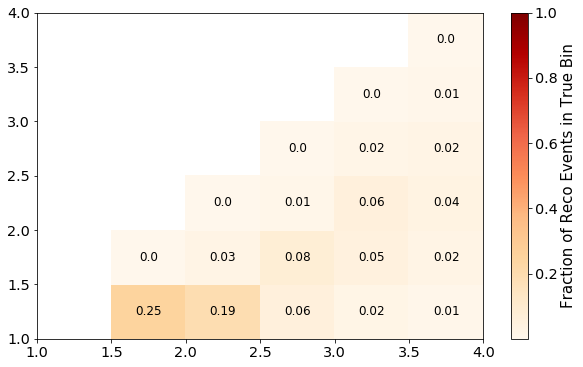

In [44]:
if isCombined == True:
    
    SPLIT = 1
    scaling = 1
    
    pot = 2e20
    nueratio  = pot/2.37838e+22 
    weights_r1 = { 
                "nue_nue"  : nueratio  * SPLIT * scaling
    }
    
    pot =  5.014e20
    nueratio  = pot/2.5345e+22
    weights_r3 = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }
    

    ###################################
    n_events_r1 = nue_nue_r1.shape[0]
    print("n_events_r1 here = ", n_events_r1)
    #print("n_events/2 here = ", np.floor(n_events_r1/2))
    print("")
    batch_size_r1 = n_events_r1

    print(n_events_r1/batch_size_r1)
    print(int(n_events_r1/batch_size_r1))


    start = 0*batch_size_r1
    if (start + batch_size_r1) < n_events_r1:
        end = start + batch_size_r1
    else:
        end = n_events_r1
    sample_set_r1 = nue_nue_r1.iloc[start:end]
    
    #####
    
    n_events_r3 = nue_nue_r3.shape[0]
    print("n_events_r3 here = ", n_events_r3)
    #print("n_events/2 here = ", np.floor(n_events_r3/2))
    print("")
    batch_size_r3 = n_events_r3

    print(n_events_r3/batch_size_r3)
    print(int(n_events_r3/batch_size_r3))


    start = 0*batch_size_r3
    if (start + batch_size_r3) < n_events_r3:
        end = start + batch_size_r3
    else:
        end = n_events_r3
    sample_set_r3 = nue_nue_r3.iloc[start:end]
    
    #########################################


    current_genie_weights_r1 = _get_genie_weight(
                    sample_set_r1, 'true_e', query=SIGNAL_NUE_SEL_QUERY_R1, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")
    current_genie_weights_r3 = _get_genie_weight(
                    sample_set_r3, 'true_e', query=SIGNAL_NUE_SEL_QUERY_R3, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

    current_genie_weights = list(current_genie_weights_r1*weights_r1["nue_nue"]) + list(current_genie_weights_r3*weights_r3["nue_nue"])
    current_genie_weights = np.array(current_genie_weights)
    
    ####

    current_genie_weights2_r1 = _get_genie_weight(
                    sample_set_r1, 'reco_e', query=SIGNAL_NUE_SEL_QUERY_R1, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")
    current_genie_weights2_r3 = _get_genie_weight(
                    sample_set_r3, 'reco_e', query=SIGNAL_NUE_SEL_QUERY_R3, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")
    
    current_genie_weights2 = list(current_genie_weights2_r1*weights_r1["nue_nue"]) + list(current_genie_weights2_r3*weights_r3["nue_nue"])
    current_genie_weights2 = np.array(current_genie_weights2)
    
    ####

    current_genie_weights3_r1 = _get_genie_weight(
                    sample_set_r1, 'true_e', query="is_signal == True", track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")
    current_genie_weights3_r3 = _get_genie_weight(
                    sample_set_r3, 'true_e', query="is_signal == True", track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

    current_genie_weights3 = list(current_genie_weights3_r1*weights_r1["nue_nue"]) + list(current_genie_weights3_r3*weights_r3["nue_nue"])
    current_genie_weights3 = np.array(current_genie_weights3)
    
    ####
    
    test_list1 = current_genie_weights
    test_list2 = current_genie_weights2

    if len(test_list1) == len(test_list2) and len(test_list1) == sum([1 for i, j in zip(test_list1, test_list2) if i == j]):
        print("All is well.")
    else:
        print("Oh no.")
        
        
    ####

    bins = np.arange(1.0, 4.5, 0.5)
    #OLD
    #bins = np.arange(0.0, 5.5, 0.5)

    var1_r1 = sample_set_r1.query(SIGNAL_NUE_SEL_QUERY_R1)['true_e']
    var1_r3 = sample_set_r3.query(SIGNAL_NUE_SEL_QUERY_R3)['true_e']
    var_temps = [var1_r1, var1_r3]
    var1 = pd.concat(var_temps)
    weight1 = current_genie_weights

    var2_r1 = sample_set_r1.query(SIGNAL_NUE_SEL_QUERY_R1)['reco_e']
    var2_r3 = sample_set_r3.query(SIGNAL_NUE_SEL_QUERY_R3)['reco_e']
    var_temps = [var2_r1, var2_r3]
    var2 = pd.concat(var_temps)
    weight2 = current_genie_weights2

    var3_r1 = sample_set_r1.query("is_signal == True")['true_e']
    var3_r3 = sample_set_r3.query("is_signal == True")['true_e']
    var_temps = [var3_r1, var3_r3]
    var3 = pd.concat(var_temps)
    weight3 = current_genie_weights3


    zerocopysmear = plot_smearing(var1, var2, weight1, weight2, var3, weight3, bins, norm=True)

In [47]:
"""
c1 = TCanvas( 'c1', 'Dynamic Filling Example', 200, 10, 700, 500 )
#c1.SetFillColor( 42 )
#c1.GetFrame().SetFillColor( 21 )
c1.GetFrame().SetBorderSize( 6 )
c1.GetFrame().SetBorderMode( -1 )

hfile = gROOT.FindObject( 'WSD_nue_energy_Flip.root' )
if hfile:
    hfile.Close()
hfile = TFile( 'WSD_nue_energy_Flip.root', 'UPDATE', 'Demo ROOT file with histograms' )

# Create some histograms, a profile histogram and an ntuple
#hpx    = TH1F( 'hpx', 'Prior Truth Input', 10, 0, 5 )
hpxpy  = TH2F( 'hR', 'Response Matrix', 10, 0, 5, 10, 0, 5 )

# Set canvas/frame attributes.
hpxpy.SetFillColor( 48 )
gBenchmark.Start( 'hsimple' )
#gStyle.SetErrorX(0.0001)

zerocopysmearT = zerocopysmear.T

n=len(zerocopysmearT)
for i in range(0, n):
    for j in range(i+1, n):
        zerocopysmearT[i][j],zerocopysmearT[j][i] = zerocopysmearT[j][i],zerocopysmearT[i][j]

#print("Flipped array: ", zerocopysmearT)


#hpxpy.Fill(1, 2, 6)
for a in range(len(bins)-1): # reco bins i (y axis) rows
    for b in range(len(bins)-1): # true bins j (x axis) cols
        hpxpy.Fill(a/2+0.25, b/2+0.25, zerocopysmearT[a][b])
        #print(total_nue_cov[a, b])

hpxpy.Draw("COLZ")
hpxpy.SetFillColor( 0 )
hpxpy.Print()
c1.Modified()
c1.Update() 
#hpxpy.SetFillColor( 48 )
c1.Modified()
c1.Update()
c1.Draw()
hfile.Write()
"""

'\nc1 = TCanvas( \'c1\', \'Dynamic Filling Example\', 200, 10, 700, 500 )\n#c1.SetFillColor( 42 )\n#c1.GetFrame().SetFillColor( 21 )\nc1.GetFrame().SetBorderSize( 6 )\nc1.GetFrame().SetBorderMode( -1 )\n\nhfile = gROOT.FindObject( \'WSD_nue_energy_Flip.root\' )\nif hfile:\n    hfile.Close()\nhfile = TFile( \'WSD_nue_energy_Flip.root\', \'UPDATE\', \'Demo ROOT file with histograms\' )\n\n# Create some histograms, a profile histogram and an ntuple\n#hpx    = TH1F( \'hpx\', \'Prior Truth Input\', 10, 0, 5 )\nhpxpy  = TH2F( \'hR\', \'Response Matrix\', 10, 0, 5, 10, 0, 5 )\n\n# Set canvas/frame attributes.\nhpxpy.SetFillColor( 48 )\ngBenchmark.Start( \'hsimple\' )\n#gStyle.SetErrorX(0.0001)\n\nzerocopysmearT = zerocopysmear.T\n\nn=len(zerocopysmearT)\nfor i in range(0, n):\n    for j in range(i+1, n):\n        zerocopysmearT[i][j],zerocopysmearT[j][i] = zerocopysmearT[j][i],zerocopysmearT[i][j]\n\n#print("Flipped array: ", zerocopysmearT)\n\n\n#hpxpy.Fill(1, 2, 6)\nfor a in range(len(bins)

In [43]:
"""
import random
import numpy
from matplotlib import pyplot

diffbins = np.arange(0, 5.5, 0.5)
count = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]
diffs = [ 2.45394694e-05,  6.82066974e-05, -3.13847238e-05, -4.80434583e-05,
 -4.20223320e-05, -1.70528259e-05, -6.10327963e-06, -2.05212261e-02,
 -1.07879793e-02, -1.04922120e-02]

pyplot.hist(count, diffbins, weights=diffs, alpha=0.5, label='Difference')
pyplot.legend(loc='lower left')
pyplot.show()

#-------------------------------------------------------
#looks at differences in single plotters and now

#reco only from single plotter
reco_sp = np.array([10.449224075510086, 31.078248422265883, 11.142672530720944, 2.7208182211142926, 1.0626423368548643, 0.3260199520259164, 0.13695140632728453, 0.0804829838961254, 0.020303320127453617, 0.02014767711723664])
truth_here = np.array([1.04492283e+01, 3.10782108e+01, 1.11426201e+01, 2.72080612e+00,
 1.06264114e+00, 3.26030731e-01, 1.36947632e-01, 5.99632263e-02,
 9.51385498e-03, 9.65881348e-03])

diffs = reco_sp - truth_here
print(diffs)
print(math.fsum(diffs))
"""

"\nimport random\nimport numpy\nfrom matplotlib import pyplot\n\ndiffbins = np.arange(0, 5.5, 0.5)\ncount = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]\ndiffs = [ 2.45394694e-05,  6.82066974e-05, -3.13847238e-05, -4.80434583e-05,\n -4.20223320e-05, -1.70528259e-05, -6.10327963e-06, -2.05212261e-02,\n -1.07879793e-02, -1.04922120e-02]\n\npyplot.hist(count, diffbins, weights=diffs, alpha=0.5, label='Difference')\npyplot.legend(loc='lower left')\npyplot.show()\n\n#-------------------------------------------------------\n#looks at differences in single plotters and now\n\n#reco only from single plotter\nreco_sp = np.array([10.449224075510086, 31.078248422265883, 11.142672530720944, 2.7208182211142926, 1.0626423368548643, 0.3260199520259164, 0.13695140632728453, 0.0804829838961254, 0.020303320127453617, 0.02014767711723664])\ntruth_here = np.array([1.04492283e+01, 3.10782108e+01, 1.11426201e+01, 2.72080612e+00,\n 1.06264114e+00, 3.26030731e-01, 1.36947632e-01, 5.99632263e-02,\n 9.513

### Now look at Efficiency

In [82]:
# from Katerina  - modified, to be able to plot truth mc with nue eff selections
# plot efficiency overlaid on selected signal events 
def plot_signal_and_eff(var1, weight1, var2, weight2, bins, variable, xaxis, title, savetitle, savetitleplot): 
    
    # generated true signal events per bin 
    gen = plt.hist(var1, bins, weights=weight1, color='deepskyblue')
    plt.close()
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(4, 5))
    
    # compute efficiency
    sel = ax1.hist(var2, bins, weights=weight2, color='white')
    print("sel = ", sel[0])
    print("")
    print("gen = ", gen[0])
    eff = [ a/b for a, b in zip(sel[0], gen[0]) ]
    eff_err = []
    for i in range(len(eff)):
        eff_err.append(math.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) )
        #eff_err.append(math.sqrt( (eff[i]*(1-eff[i]))/ sel[0][i] ) )
        print("In bin", i, ", ", title ," = ", eff[i], " with error = ", eff_err[i])
        
    eff_tot = sum(sel[0])/sum(gen[0])
    print("Total ", title)
    print(eff_tot)
        
    # compute bin centers 
    bc = 0.5*(sel[1][1:]+sel[1][:-1])
    x_err = []
    for i in range(len(sel[1])-1): 
        x_err.append((sel[1][i+1]-sel[1][i])/2)

    # plot efficiency
    ax1.errorbar(bc, eff, xerr=x_err, yerr=eff_err, fmt='o', color='orangered', ecolor='orangered', markersize=3) 
    ax1.set_ylim(0, 1)

    #ax1.set_ylabel('Efficiency', fontsize=15)
    #ax1.set_title("Efficiency")
    ax1.set_ylabel(title, fontsize=15)
    ax1.set_title(title)
    ax1.set_xlabel(xaxis)
    
    np.savetxt(savetitle,
           eff,
           delimiter =", ", 
           fmt ='% s')
    
    print("Plot title: ", savetitleplot)
    fig.savefig(savetitleplot,bbox_inches='tight' )

    plt.show()

In [83]:
#ENERGY
# Efficiency =  tot_sig_sel/tot_sig
#-----------------------------------------------------------------------------------
##SEL_QUERY + fidq = TOTAL_QUERY
if isCombined == False:
    bins = np.arange(0, 5.5, 0.5)
    scaling = 1
    SPLIT = 1.0

    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22 

    # NUMU
    weights = { #full sample mc = 0.38
                "nue_nue"  : nueratio  * SPLIT * scaling
    }

    current_genie_weights = _get_genie_weight(
                    nue_nue, 'true_e', query=("is_signal == True"), track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

    current_genie_weights2 = _get_genie_weight(
                    nue_nue, 'true_e', query=TOTAL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")


    var1 = nue_nue.query("is_signal == True")['true_e']
    weight1 = current_genie_weights* weights["nue_nue"]
    if isRun3 == False and isCombined == False:
        var1.to_csv("nue_full_var1_eff_recoCut_"+ending+".csv")
        np.savetxt("nue_full_weight1_eff_recoCut_"+ending+".csv", 
                    weight1,
                    delimiter =", ", 
                    fmt ='% s')
    if isRun3 == True and isCombined == False:
        var1.to_csv("nue_full_var1_eff_recoCut_run3_"+ending+".csv")
        np.savetxt("nue_full_weights1_eff_recoCut_run3_"+ending+".csv", 
                    weight1,
                    delimiter =", ", 
                    fmt ='% s') 

    var2 = nue_nue.query(TOTAL_QUERY)['true_e']
    weight2 = current_genie_weights2 * weights["nue_nue"]
    if isRun3 == False and isCombined == False:
        var2.to_csv("nue_full_var2_eff_recoCut_"+ending+".csv")
        np.savetxt("nue_full_weight2_eff_recoCut_"+ending+".csv", 
                    weight2,
                    delimiter =", ", 
                    fmt ='% s')
    if isRun3 == True and isCombined == False:
        var2.to_csv("nue_full_var2_eff_recoCut_run3_"+ending+".csv")
        np.savetxt("nue_full_weights2_eff_recoCut_run3_"+ending+".csv", 
                    weight2,
                    delimiter =", ", 
                    fmt ='% s')


    ###########################################

    variable = 'true_e'
    xaxis = "True Neutrino Energy [GeV]"
    if isRun3 == False and isCombined == False:
        savetitle = "batch_eff_nue_fig_full_500_catsel_nopions_recoE_matrix_trueeff_"+ending+".csv"
    if isRun3 == True and isCombined == False:
        savetitle = "batch_eff_nue_fig_full_500_catsel_nopions_recoE_matrix_trueeff_run3_"+ending+".csv"

    plot_signal_and_eff(var1, weight1, var2, weight2, bins, variable, xaxis, "Efficiency", savetitle)

sel =  [ 0.          0.         23.86062813 73.99440765 33.11981964 12.27842712
  5.79206848  2.85072327  1.18223572  0.73641968]

gen =  [  0.           0.         197.93907166 364.49121094 194.72344971
  88.86126709  44.08068848  26.19732666  13.65899658   7.22839355]
In bin 0 ,  Efficiency  =  nan  with error =  nan
In bin 1 ,  Efficiency  =  nan  with error =  nan
In bin 2 ,  Efficiency  =  0.12054531694281627  with error =  0.023142812670592698
In bin 3 ,  Efficiency  =  0.20300738518080907  with error =  0.02106878721376451
In bin 4 ,  Efficiency  =  0.1700864466552092  with error =  0.026924159534408312
In bin 5 ,  Efficiency  =  0.13817524244403645  with error =  0.036607354908931446
In bin 6 ,  Efficiency  =  0.13139696047453817  with error =  0.05088375436459285
In bin 7 ,  Efficiency  =  0.10881733482131416  with error =  0.06084206137150224
In bin 8 ,  Efficiency  =  0.08655362864126476  with error =  0.07608074719207986
In bin 9 ,  Efficiency  =  0.10187874693912015  with 

/tmp/ipykernel_6468/773431157.py:17: RuntimeWarning: invalid value encountered in double_scalars
  eff = [ a/b for a, b in zip(sel[0], gen[0]) ]


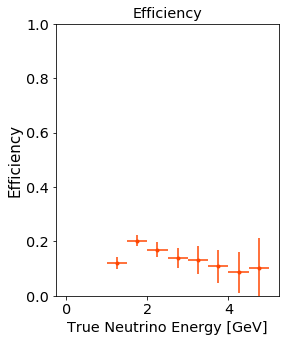

In [84]:
#ENERGY
# Efficiency =  tot_sig_sel/tot_sig
#-----------------------------------------------------------------------------------
##SEL_QUERY + fidq = TOTAL_QUERY
bins = np.arange(0, 5.5, 0.5)
scaling = 1
SPLIT = 1.0

SPLIT = 1
scaling = 1

pot = 2e20
nueratio  = pot/2.37838e+22 
weights_r1 = { 
            "nue_nue"  : nueratio  * SPLIT * scaling
}

pot =  5.014e20
nueratio  = pot/2.5345e+22
weights_r3 = {
            "nue_nue"  : nueratio  * SPLIT * scaling
}

#current_genie_weights = _get_genie_weight(
#                nue_nue, 'true_e', query=truthsel_nue_only, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

#current_genie_weights2 = _get_genie_weight(
#                nue_nue, 'true_e', query=TOTAL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")
######
current_genie_weights_r1 = _get_genie_weight(
                sample_set_r1, 'true_e', query=("is_signal == True"), track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")
current_genie_weights_r3 = _get_genie_weight(
                sample_set_r3, 'true_e', query=("is_signal == True"), track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

current_genie_weights = list(current_genie_weights_r1*weights_r1["nue_nue"]) + list(current_genie_weights_r3*weights_r3["nue_nue"])
current_genie_weights = np.array(current_genie_weights)

####

current_genie_weights2_r1 = _get_genie_weight(
                sample_set_r1, 'true_e', query=SIGNAL_NUE_SEL_QUERY_R1, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")
current_genie_weights2_r3 = _get_genie_weight(
                sample_set_r3, 'true_e', query=SIGNAL_NUE_SEL_QUERY_R3, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

current_genie_weights2 = list(current_genie_weights2_r1*weights_r1["nue_nue"]) + list(current_genie_weights2_r3*weights_r3["nue_nue"])
current_genie_weights2 = np.array(current_genie_weights2)

####################################

#var1 = nue_nue.query(truthsel_nue_only)['true_e']
#weight1 = current_genie_weights* weights["nue_nue"]

#var2 = nue_nue.query(TOTAL_QUERY)['true_e']
#weight2 = current_genie_weights2 * weights["nue_nue"]

#####

var1_r1 = sample_set_r1.query("is_signal == True")['true_e']
var1_r3 = sample_set_r3.query("is_signal == True")['true_e']
var_temps = [var1_r1, var1_r3]
var1 = pd.concat(var_temps)
weight1 = current_genie_weights

var2_r1 = sample_set_r1.query(SIGNAL_NUE_SEL_QUERY_R1)['true_e']
var2_r3 = sample_set_r3.query(SIGNAL_NUE_SEL_QUERY_R3)['true_e']
var_temps = [var2_r1, var2_r3]
var2 = pd.concat(var_temps)
weight2 = current_genie_weights2


###########################################

variable = 'true_e'
xaxis = "True Neutrino Energy [GeV]"
savetitle = "batch_eff_nue_fig_full_500_catsel_nopions_recoE_matrix_trueeff_"+ending+".csv"
savetitleplot = "batch_eff_nue_fig_full_500_catsel_nopions_recoE_matrix_trueeff_"+ending+".svg"

plot_signal_and_eff(var1, weight1, var2, weight2, bins, variable, xaxis, "Efficiency", savetitle, savetitleplot)

sel =  [ 0.          0.          9.79615307 39.58561707 27.15719986 10.76882172
  5.88690948  3.48423004  1.6629715   1.00867462]

gen =  [ 0.17244861  0.43106547 11.4994812  47.16551208 32.81334305 13.73830414
  7.24046326  4.26715088  2.29691315  1.23999023]
In bin 0 , eff =  0.0  with error =  0.0
In bin 1 , eff =  0.0  with error =  0.0
In bin 2 , eff =  0.8518778279792472  with error =  0.10475133572847772
In bin 3 , eff =  0.8392915780098537  with error =  0.0534765614054195
In bin 4 , eff =  0.827626731595554  with error =  0.06593666443807496
In bin 5 , eff =  0.7838537863183739  with error =  0.11105159053050853
In bin 6 , eff =  0.8130570208066831  with error =  0.144887828975169
In bin 7 , eff =  0.8165237509476063  with error =  0.18737227848876065
In bin 8 , eff =  0.7240027768458884  with error =  0.2949512122538441
In bin 9 , eff =  0.8134536818271313  with error =  0.34982482302884166
Total Eff
0.8219984852247074


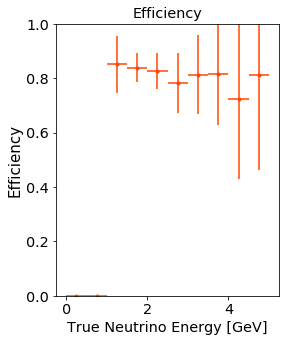

In [46]:
"""
#Purity =  tot_sig_sel/tot_sel
##SEL_QUERY + fidq = TOTAL_QUERY
if isCombined == False:
    bins = np.arange(0, 5.5, 0.5)
    scaling = 1
    SPLIT = 1.0

    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22 

    # NUMU
    weights = { #full sample mc = 0.38
                "nue_nue"  : nueratio  * SPLIT * scaling
    }

    current_genie_weights = _get_genie_weight(
                    nue_nue, 'true_e', query=SEL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

    current_genie_weights2 = _get_genie_weight(
                    nue_nue, 'true_e', query=TOTAL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")


    var1 = nue_nue.query(SEL_QUERY)['true_e']
    weight1 = current_genie_weights* weights["nue_nue"]
    if isRun3 == False and isCombined == False:
        var1.to_csv("nue_full_var1_pur_recoCut_"+ending+".csv")
        np.savetxt("nue_full_weight1_pur_recoCut_"+ending+".csv", 
                    weight1,
                    delimiter =", ", 
                    fmt ='% s')
    if isRun3 == True and isCombined == False:
        var1.to_csv("nue_full_var1_pur_recoCut_run3_"+ending+".csv")
        np.savetxt("nue_full_weights1_pur_recoCut_run3_"+ending+".csv", 
                    weight1,
                    delimiter =", ", 
                    fmt ='% s') 

    var2 = nue_nue.query(TOTAL_QUERY)['true_e']
    weight2 = current_genie_weights2 * weights["nue_nue"]
    if isRun3 == False and isCombined == False:
        var2.to_csv("nue_full_var2_pur_recoCut_"+ending+".csv")
        np.savetxt("nue_full_weight2_pur_recoCut_"+ending+".csv", 
                    weight2,
                    delimiter =", ", 
                    fmt ='% s')
    if isRun3 == True and isCombined == False:
        var2.to_csv("nue_full_var2_pur_recoCut_run3_"+ending+".csv")
        np.savetxt("nue_full_weights2_pur_recoCut_run3_"+ending+".csv", 
                    weight2,
                    delimiter =", ", 
                    fmt ='% s')


    ###########################################

    variable = 'true_e'
    xaxis = "True Neutrino Energy [GeV]"
    if isRun3 == False and isCombined == False:
        savetitle = "batch_eff_nue_fig_full_500_catsel_nopions_recoE_matrix_trupur_"+ending+".csv"
    if isRun3 == True and isCombined == False:
        savetitle = "batch_eff_nue_fig_full_500_catsel_nopions_recoE_matrix_truepur_run3_"+ending+".csv"

    plot_signal_and_eff(var1, weight1, var2, weight2, bins, variable, xaxis, savetitle)
"""

sel =  [ 0.          0.         22.04151535 73.53161621 33.61290741 12.62159729
  6.06472778  2.93301392  1.29025269  0.73100281]

gen =  [ 0.33539471  0.8279562  25.28137398 86.80693817 41.75834656 15.94030762
  7.66630554  3.95779419  1.8039856   0.87142944]
In bin 0 ,  Purity  =  0.0  with error =  0.0
In bin 1 ,  Purity  =  0.0  with error =  0.0
In bin 2 ,  Purity  =  0.8718480004218874  with error =  0.06647873470155855
In bin 3 ,  Purity  =  0.8470707268324662  with error =  0.038630286575336195
In bin 4 ,  Purity  =  0.8049386573122493  with error =  0.061319040427013236
In bin 5 ,  Purity  =  0.7918038718669352  with error =  0.1016943408591952
In bin 6 ,  Purity  =  0.7910887128074376  with error =  0.1468251605618448
In bin 7 ,  Purity  =  0.741072874337839  with error =  0.22018748469638927
In bin 8 ,  Purity  =  0.7152233857188774  with error =  0.3360133105635223
In bin 9 ,  Purity  =  0.838854841533882  with error =  0.393854601572537
Total  Purity
0.8249758275074418
Plo

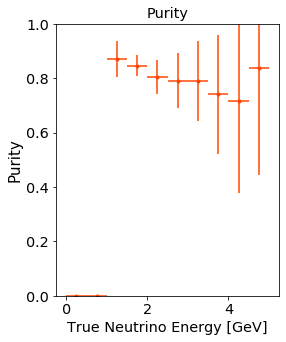

In [66]:
"""
#ENERGY
#Same thing different inputs for purity
#Purity =  tot_sig_sel/tot_sel
#-----------------------------------------------------------------------------------
##SEL_QUERY + fidq = TOTAL_QUERY
bins = np.arange(0, 5.5, 0.5)
scaling = 1
SPLIT = 1.0

pot = 2e20
nueratio  = pot/2.37838e+22 
weights_r1 = { 
            "nue_nue"  : nueratio  * SPLIT * scaling
}

pot =  5.014e20
nueratio  = pot/2.5345e+22
weights_r3 = {
            "nue_nue"  : nueratio  * SPLIT * scaling
}

current_genie_weights_r1 = _get_genie_weight(
                sample_set_r1, 'true_e', query=(SEL_QUERY), track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")
current_genie_weights_r3 = _get_genie_weight(
                sample_set_r3, 'true_e', query=(SEL_QUERY), track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

current_genie_weights = list(current_genie_weights_r1*weights_r1["nue_nue"]) + list(current_genie_weights_r3*weights_r3["nue_nue"])
current_genie_weights = np.array(current_genie_weights)

####

current_genie_weights2_r1 = _get_genie_weight(
                sample_set_r1, 'true_e', query=TOTAL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")
current_genie_weights2_r3 = _get_genie_weight(
                sample_set_r3, 'true_e', query=TOTAL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

current_genie_weights2 = list(current_genie_weights2_r1*weights_r1["nue_nue"]) + list(current_genie_weights2_r3*weights_r3["nue_nue"])
current_genie_weights2 = np.array(current_genie_weights2)

####################################

var1_r1 = sample_set_r1.query(SEL_QUERY)['true_e']
var1_r3 = sample_set_r3.query(SEL_QUERY)['true_e']
var_temps = [var1_r1, var1_r3]
var1 = pd.concat(var_temps)
weight1 = current_genie_weights

var2_r1 = sample_set_r1.query(TOTAL_QUERY)['true_e']
var2_r3 = sample_set_r3.query(TOTAL_QUERY)['true_e']
var_temps = [var2_r1, var2_r3]
var2 = pd.concat(var_temps)
weight2 = current_genie_weights2


###########################################

variable = 'true_e'
xaxis = "True Neutrino Energy [GeV]"
savetitle = "batch_eff_nue_fig_full_500_catsel_nopions_recoE_matrix_truepur_"+ending+".csv"
savetitleplot = "batch_eff_nue_fig_full_500_catsel_nopions_recoE_matrix_truepur_"+ending+".svg"

plot_signal_and_eff(var1, weight1, var2, weight2, bins, variable, xaxis, "Purity", savetitle, savetitleplot)
"""

In [34]:
"""
Summed_Smearcept_Norm = np.array([0.110120914586509757726595637450373033061623573303222656250000,
0.181676672368888458830582521841279231011867523193359375000000,
0.157362502267561515933991245219658594578504562377929687500000,
0.119950280049570312534967797546414658427238464355468750000000,
0.122151057111602373561609624630364123731851577758789062500000,
0.082218763385204562954555740361684001982212066650390625000000,
0.070955077675279046300893526222353102639317512512207031250000,
0.080226544975481511867698714013386052101850509643554687500000,
0.066831567493958340953064123368676519021391868591308593750000,
0.057013526072099932062720029080082895234227180480957031250000])

effs = np.array([0.1101209435531451,
0.18167666321461892,
0.15736196529782268,
0.11994939664562915,
0.12215133952900578,
0.08221884442411206,
0.07095395173368216,
0.08022868046918818,
0.06682939978435366,
0.057014870794734274])

diffs = Summed_Smearcept_Norm - effs
print(diffs)

diffbins = np.arange(0, 5.5, 0.5)
count = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]

pyplot.hist(count, diffbins, weights=diffs, alpha=0.5, label='Difference')
pyplot.legend(loc='lower left')
pyplot.show()
"""

"\nSummed_Smearcept_Norm = np.array([0.110120914586509757726595637450373033061623573303222656250000,\n0.181676672368888458830582521841279231011867523193359375000000,\n0.157362502267561515933991245219658594578504562377929687500000,\n0.119950280049570312534967797546414658427238464355468750000000,\n0.122151057111602373561609624630364123731851577758789062500000,\n0.082218763385204562954555740361684001982212066650390625000000,\n0.070955077675279046300893526222353102639317512512207031250000,\n0.080226544975481511867698714013386052101850509643554687500000,\n0.066831567493958340953064123368676519021391868591308593750000,\n0.057013526072099932062720029080082895234227180480957031250000])\n\neffs = np.array([0.1101209435531451,\n0.18167666321461892,\n0.15736196529782268,\n0.11994939664562915,\n0.12215133952900578,\n0.08221884442411206,\n0.07095395173368216,\n0.08022868046918818,\n0.06682939978435366,\n0.057014870794734274])\n\ndiffs = Summed_Smearcept_Norm - effs\nprint(diffs)\n\ndiffbins = np.ar

In [1]:
"""
# ANGLE

#this is the truth selection
fiduc_q = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
fiduc_q  += " and category == 11"

variable = 'cosNu_Angle_Numi_Elec_asmuon'
xaxis = "cos(Lepton Angle)"
savetitle = "batch_eff_nue_fig_full_500_catsel_nopions_AngleDiff_matrix_trueeff.csv"


bin_width = 0.2
bins = np.arange(-1, 1, bin_width)
#plot_signal_and_eff(selected, nue, fiduc_q, bins, mc.query(fiduc_q))

selected = nue_nue.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

#had truth as mc - should be nue?
plot_signal_and_eff(selected_fid, nue_nue, fiduc_q, bins, variable, xaxis, savetitle)
"""

'\n# ANGLE\n\n#this is the truth selection\nfiduc_q = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"\nfiduc_q  += " and category == 11"\n\nvariable = \'cosNu_Angle_Numi_Elec_asmuon\'\nxaxis = "cos(Lepton Angle)"\nsavetitle = "batch_eff_nue_fig_full_500_catsel_nopions_AngleDiff_matrix_trueeff.csv"\n\n\nbin_width = 0.2\nbins = np.arange(-1, 1, bin_width)\n#plot_signal_and_eff(selected, nue, fiduc_q, bins, mc.query(fiduc_q))\n\nselected = nue_nue.query(SEL_QUERY)\nselected_fid = selected.query(fiduc_q)\n\n#had truth as mc - should be nue?\nplot_signal_and_eff(selected_fid, nue_nue, fiduc_q, bins, variable, xaxis, savetitle)\n'

In [2]:
"""
# LEPTON MOMENTUM

#this is the truth selection
fiduc_q = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
fiduc_q  += " and category == 11"

variable = 'targetP_asmuon'
xaxis = "True Lepton Momentum [GeV]"
savetitle = "batch_eff_nue_fig_full_500_catsel_nopions_LeptonMom_matrix_trueeff.csv"


bin_width = 0.5
bins = np.arange(0, 5.0, bin_width)
#plot_signal_and_eff(selected, nue, fiduc_q, bins, mc.query(fiduc_q))

selected = nue_nue.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

#had truth as mc - should be nue?
plot_signal_and_eff(selected_fid, nue_nue, fiduc_q, bins, variable, xaxis, savetitle)
"""

'\n# LEPTON MOMENTUM\n\n#this is the truth selection\nfiduc_q = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"\nfiduc_q  += " and category == 11"\n\nvariable = \'targetP_asmuon\'\nxaxis = "True Lepton Momentum [GeV]"\nsavetitle = "batch_eff_nue_fig_full_500_catsel_nopions_LeptonMom_matrix_trueeff.csv"\n\n\nbin_width = 0.5\nbins = np.arange(0, 5.0, bin_width)\n#plot_signal_and_eff(selected, nue, fiduc_q, bins, mc.query(fiduc_q))\n\nselected = nue_nue.query(SEL_QUERY)\nselected_fid = selected.query(fiduc_q)\n\n#had truth as mc - should be nue?\nplot_signal_and_eff(selected_fid, nue_nue, fiduc_q, bins, variable, xaxis, savetitle)\n'

### Combined Loading and Calculation

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
sel1 =  [ 0.          0.         14.73908424 63.60956706 42.17783004 16.04082315
  8.31257665  4.33718069  2.25956996  1.30305206]
sum sel1 =  152.77968385448395

sel2 =  [2.28388653e+01 7.72080277e+01 3.55178247e+01 1.09566549e+01
 4.20505441e+00 1.54243170e+00 4.35153137e-01 5.54237720e-02
 0.00000000e+00 2.02481910e-02]
sum sel2 =  152.77968385448384

truth - reco (sel1 - sel2) 
[-22.83886534 -77.20802769 -20.77874042  52.65291211  37.97277563
  14.49839145   7.87742351   4.28175692   2.25956996   1.28280387]
1.1368683772161603e-13
---------------------------------------------------------

GENERATED
[  0.           0.         146.23080361 326.30945436 218.20886807
 108.97573476  60.15403756  32.49329603  21.35396417  13.08646446]

ZERO COPY SMEAR NORM
[[0.         0.         0.08294057 0.02768928 0.00640102 0.00152943
  0.00113127 0.00066355 0.00063474 0.00065189]
 [0.         0.         0.01785273 0.16097066 0.08328069 0.0

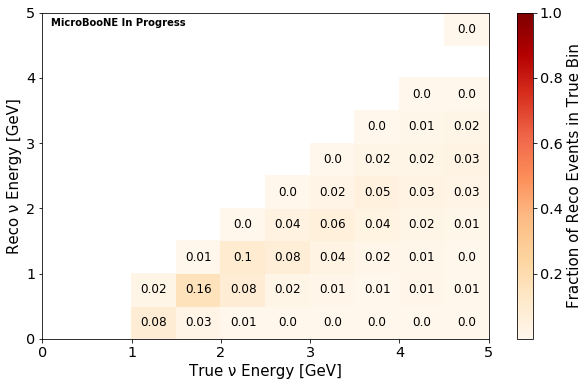

In [50]:
#####Smearing####
smearing_var1_run1 = pd.read_csv("nue_full_var1_recoCut_"+ending+".csv")

with open('nue_full_weight1_recoCut_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight1_run1 = list(csv_reader)

for a in range(len(smearing_weight1_run1)):
    smearing_weight1_run1[a] = float(smearing_weight1_run1[a][0])
### 
smearing_var2_run1 = pd.read_csv("nue_full_var2_recoCut_"+ending+".csv")

with open('nue_full_weight2_recoCut_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight2_run1 = list(csv_reader)

for a in range(len(smearing_weight2_run1)):
    smearing_weight2_run1[a] = float(smearing_weight2_run1[a][0])
### 
smearing_var3_run1 = pd.read_csv("nue_full_var3_recoCut_"+ending+".csv")

with open('nue_full_weight3_recoCut_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight3_run1 = list(csv_reader)

for a in range(len(smearing_weight3_run1)):
    smearing_weight3_run1[a] = float(smearing_weight3_run1[a][0])
###---####
smearing_var1_run3 = pd.read_csv("nue_full_var1_recoCut_run3_"+ending+".csv")

with open('nue_full_weights1_recoCut_run3_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight1_run3 = list(csv_reader)

for a in range(len(smearing_weight1_run3)):
    smearing_weight1_run3[a] = float(smearing_weight1_run3[a][0])
### 
smearing_var2_run3 = pd.read_csv("nue_full_var2_recoCut_run3_"+ending+".csv")

with open('nue_full_weights2_recoCut_run3_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight2_run3 = list(csv_reader)

for a in range(len(smearing_weight2_run3)):
    smearing_weight2_run3[a] = float(smearing_weight2_run3[a][0])
### 
smearing_var3_run3 = pd.read_csv("nue_full_var3_recoCut_run3_"+ending+".csv")

with open('nue_full_weights3_recoCut_run3_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight3_run3 = list(csv_reader)

for a in range(len(smearing_weight3_run3)):
    smearing_weight3_run3[a] = float(smearing_weight3_run3[a][0])
    
####################Add#####################

var_temps = [smearing_var1_run1, smearing_var1_run3]
var1 = pd.concat(var_temps)
var1 = var1.drop(["entry"], axis=1)
var1 = var1.squeeze()
weight1 = list(smearing_weight1_run1) + list(smearing_weight1_run3)
weight1 = np.array(weight1)

print(type(var1))
print(type(weight1))

var_temps = [smearing_var2_run1, smearing_var2_run3]
var2 = pd.concat(var_temps)
var2 = var2.drop(["entry"], axis=1)
var2 = var2.squeeze()
weight2 = list(smearing_weight2_run1) + list(smearing_weight2_run3)
weight2 = np.array(weight2)

var_temps = [smearing_var3_run1, smearing_var3_run3]
var3 = pd.concat(var_temps)
var3 = var3.drop(["entry"], axis=1)
var3 = var3.squeeze()
weight3 = list(smearing_weight3_run1) + list(smearing_weight3_run3)
weight3 = np.array(weight3)

bins = np.arange(0, 5.5, 0.5)

isCombined = True

zerocopysmear = plot_smearing(var1, var2, weight1, weight2, var3, weight3, bins, norm=True)

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
sel =  [ 0.          0.         14.73908424 63.60956706 42.17783004 16.04082315
  8.31257665  4.33718069  2.25956996  1.30305206]

gen =  [  0.           0.         146.23080361 326.30945436 218.20886807
 108.97573476  60.15403756  32.49329603  21.35396417  13.08646446]
In bin 0 , eff =  nan  with error =  nan
In bin 1 , eff =  nan  with error =  nan
In bin 2 , eff =  0.10079329306207685  with error =  0.02489580379707613
In bin 3 , eff =  0.19493632873403396  with error =  0.02193040628432077
In bin 4 , eff =  0.19329109037802078  with error =  0.026731796510832483
In bin 5 , eff =  0.14719628353174966  with error =  0.03393970488336517
In bin 6 , eff =  0.13818817465354216  with error =  0.04449480146286486
In bin 7 , eff =  0.13347924711365278  with error =  0.05966222900697326
In bin 8 , eff =  0.10581501104727958  with error =  0.06656532754823592
In bin 9 , eff =  0.09957250622296918  with error =  0.08277190066635771
To

/tmp/ipykernel_5422/2209692852.py:17: RuntimeWarning: invalid value encountered in double_scalars
  eff = [ a/b for a, b in zip(sel[0], gen[0]) ]


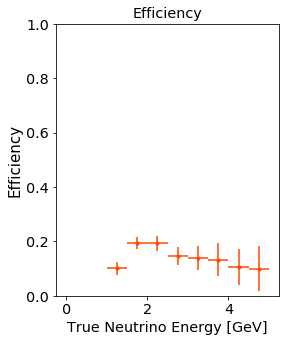

In [51]:

#####Efficiency####
smearing_var1_run1 = pd.read_csv("nue_full_var1_eff_recoCut_"+ending+".csv")

with open('nue_full_weight1_eff_recoCut_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight1_run1 = list(csv_reader)

for a in range(len(smearing_weight1_run1)):
    smearing_weight1_run1[a] = float(smearing_weight1_run1[a][0])
### 
smearing_var2_run1 = pd.read_csv("nue_full_var2_eff_recoCut_"+ending+".csv")

with open('nue_full_weight2_eff_recoCut_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight2_run1 = list(csv_reader)

for a in range(len(smearing_weight2_run1)):
    smearing_weight2_run1[a] = float(smearing_weight2_run1[a][0])
###---####
smearing_var1_run3 = pd.read_csv("nue_full_var1_eff_recoCut_run3_"+ending+".csv")

with open('nue_full_weights1_eff_recoCut_run3_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight1_run3 = list(csv_reader)

for a in range(len(smearing_weight1_run3)):
    smearing_weight1_run3[a] = float(smearing_weight1_run3[a][0])
### 
smearing_var2_run3 = pd.read_csv("nue_full_var2_eff_recoCut_run3_"+ending+".csv")

with open('nue_full_weights2_eff_recoCut_run3_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight2_run3 = list(csv_reader)

for a in range(len(smearing_weight2_run3)):
    smearing_weight2_run3[a] = float(smearing_weight2_run3[a][0])
    
####################Add#####################

var_temps = [smearing_var1_run1, smearing_var1_run3]
var1 = pd.concat(var_temps)
var1 = var1.drop(["entry"], axis=1)
var1 = var1.squeeze()
weight1 = list(smearing_weight1_run1) + list(smearing_weight1_run3)
weight1 = np.array(weight1)

print(type(var1))
print(type(weight1))

var_temps = [smearing_var2_run1, smearing_var2_run3]
var2 = pd.concat(var_temps)
var2 = var2.drop(["entry"], axis=1)
var2 = var2.squeeze()
weight2 = list(smearing_weight2_run1) + list(smearing_weight2_run3)
weight2 = np.array(weight2)


bins = np.arange(0, 5.5, 0.5)

variable = 'true_e'
xaxis = "True Neutrino Energy [GeV]"
isCombined = True
if isCombined == True:
    savetitle = "batch_eff_nue_fig_full_500_catsel_nopions_recoE_matrix_trueeff_comb_"+ending+".csv"

plot_signal_and_eff(var1, weight1, var2, weight2, bins, variable, xaxis, savetitle)

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
sel =  [ 0.          0.         14.73908424 63.60956706 42.17783004 16.04082315
  8.31257665  4.33718069  2.25956996  1.30305206]

gen =  [ 0.29496173  0.54765538 17.28815876 74.25996596 50.35603741 20.12802419
 10.21012609  5.63737407  3.12605022  1.6968264 ]
In bin 0 , eff =  0.0  with error =  0.0
In bin 1 , eff =  0.0  with error =  0.0
In bin 2 , eff =  0.8525537303592343  with error =  0.08527140192741073
In bin 3 , eff =  0.856579534304505  with error =  0.040673546138947476
In bin 4 , eff =  0.8375923168638384  with error =  0.05197492294807473
In bin 5 , eff =  0.7969397792854311  with error =  0.08966534147314086
In bin 6 , eff =  0.814150244133023  with error =  0.12173563444708219
In bin 7 , eff =  0.7693618758869478  with error =  0.17741586487466907
In bin 8 , eff =  0.7228194672572519  with error =  0.2531618773170567
In bin 9 , eff =  0.7679348124721299  with error =  0.3240771938084666
Total Eff
0.832381889194

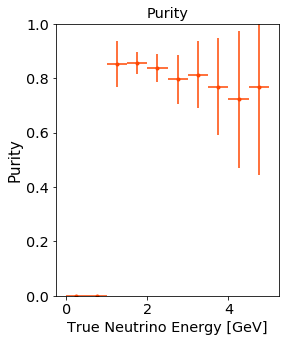

In [13]:
"""
#####Purity####
smearing_var1_run1 = pd.read_csv("nue_full_var1_pur_recoCut_"+ending+".csv")

with open('nue_full_weight1_pur_recoCut_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight1_run1 = list(csv_reader)

for a in range(len(smearing_weight1_run1)):
    smearing_weight1_run1[a] = float(smearing_weight1_run1[a][0])
### 
smearing_var2_run1 = pd.read_csv("nue_full_var2_pur_recoCut_"+ending+".csv")

with open('nue_full_weight2_pur_recoCut_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight2_run1 = list(csv_reader)

for a in range(len(smearing_weight2_run1)):
    smearing_weight2_run1[a] = float(smearing_weight2_run1[a][0])
###---####
smearing_var1_run3 = pd.read_csv("nue_full_var1_pur_recoCut_run3_"+ending+".csv")

with open('nue_full_weights1_pur_recoCut_run3_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight1_run3 = list(csv_reader)

for a in range(len(smearing_weight1_run3)):
    smearing_weight1_run3[a] = float(smearing_weight1_run3[a][0])
### 
smearing_var2_run3 = pd.read_csv("nue_full_var2_pur_recoCut_run3_"+ending+".csv")

with open('nue_full_weights2_pur_recoCut_run3_'+ending+'.csv', 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        smearing_weight2_run3 = list(csv_reader)

for a in range(len(smearing_weight2_run3)):
    smearing_weight2_run3[a] = float(smearing_weight2_run3[a][0])
    
####################Add#####################

var_temps = [smearing_var1_run1, smearing_var1_run3]
var1 = pd.concat(var_temps)
var1 = var1.drop(["entry"], axis=1)
var1 = var1.squeeze()
weight1 = list(smearing_weight1_run1) + list(smearing_weight1_run3)
weight1 = np.array(weight1)

print(type(var1))
print(type(weight1))

var_temps = [smearing_var2_run1, smearing_var2_run3]
var2 = pd.concat(var_temps)
var2 = var2.drop(["entry"], axis=1)
var2 = var2.squeeze()
weight2 = list(smearing_weight2_run1) + list(smearing_weight2_run3)
weight2 = np.array(weight2)


bins = np.arange(0, 5.5, 0.5)

variable = 'true_e'
xaxis = "True Neutrino Energy [GeV]"
isCombined = True
if isCombined == True:
    savetitle = "batch_eff_nue_fig_full_500_catsel_nopions_recoE_matrix_truepur_comb_"+ending+".csv"

plot_signal_and_eff(var1, weight1, var2, weight2, bins, variable, xaxis, savetitle)
"""

########################################################################

# OLD from here

### Smearing Matrix work

In [52]:
# plot the smearing matrix 
def plot_smearing(selected, signal, df, true, reco, bins, norm=False): 
    fig = plt.figure(figsize=(10, 6))
    
    smear = plt.hist2d(selected.query(signal)[true],selected.query(signal)[reco],
                   bins, cmin=0.000000001, cmap='OrRd')
    
    zero_copy_smear = np.copy(smear[0].T)
    
    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if np.isnan(zero_copy_smear[i,j]):
                zero_copy_smear[i,j]= 0

    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if smear[0].T[i,j] > 0: 
                if smear[0].T[i,j]>80: 
                    col='white'
                else: 
                    col='black'
                    
                binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                        
                plt.text(binx_centers, biny_centers, round(smear[0].T[i,j], 1), 
                    color=col, ha="center", va="center", fontsize=12)

    cbar = plt.colorbar()
    cbar.set_label('Selected Signal Events', fontsize=15)

    if norm: 
        plt.close()
        
        norm_array = smear[0].T
        
        gen = plt.hist(df.query(signal)['nu_e'], bins, color='deepskyblue')
        print(gen[0])
        plt.close()
    
        # for each truth bin (column): 
        for j in range(len(bins)-1): 
        
            #reco_events_in_column = [ norm_array[i][j] for i in range(len(bins)-1) ]
            #tot_reco_events = np.nansum(reco_events_in_column)
        
            # replace with normalized value 
            for i in range(len(bins)-1):
                norm_array[i][j] =  norm_array[i][j] / gen[0][j]
    
        # now plot
        fig = plt.figure(figsize=(10, 6))
        plt.pcolor(bins, bins, norm_array, cmap='OrRd', vmax=1)
        
        zero_copy_smear_norm = np.copy(norm_array)

        for i in range(len(bins)-1): # reco bins i (y axis) rows
            for j in range(len(bins)-1): # true bins j (x axis) cols
                if np.isnan(zero_copy_smear_norm[i,j]):
                    zero_copy_smear_norm[i,j]= 0

        print(zero_copy_smear_norm)
    
        # Loop over data dimensions and create text annotations.
        for i in range(len(bins)-1): # reco bins (rows)
            for j in range(len(bins)-1): # truth bins (cols)
                if norm_array[i][j]>0: 
                
                    if norm_array[i][j]>0.7: 
                        col = 'white'
                    else: 
                        col = 'black'
                    
                    binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                    biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                
                    plt.text(binx_centers, biny_centers, round(norm_array[i][j], 2), 
                         ha="center", va="center", color=col, fontsize=12)
      
        cbar = plt.colorbar()
        cbar.set_label('Fraction of Reco Events in True Bin', fontsize=15)
        
        np.savetxt("nue_full_500_catsel_nopions_recoE_usingSelection_smearcept.csv", 
           zero_copy_smear_norm,
           delimiter =", ", 
           fmt ='% s')

    plt.xlabel('True ν Energy [GeV]', fontsize=15)
    plt.ylabel('Reco ν Energy [GeV]', fontsize=15)
    plt.text(0.1, 4.8, r'MicroBooNE In Progress', fontweight='bold')
    
    plt.show()

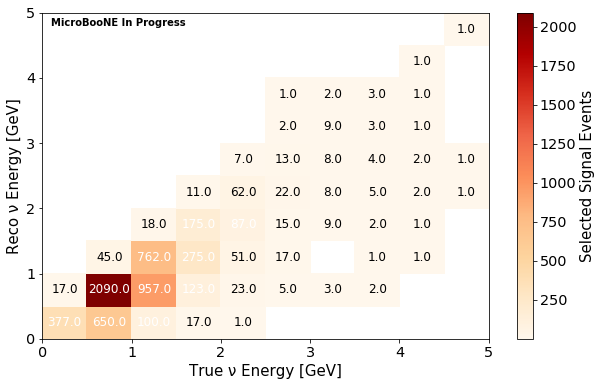

In [53]:
# true nu energy 
true_var = 'nu_e'

# reconstructed nu energy 
reco_var = 'reco_e'

bins = np.arange(0, 5.5, 0.5)

#fiduc_q = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and ((nu_pdg) == 12 and ccnc == 0) and nproton > 0"

fiduc_q  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
fiduc_q  += " and category == 11"

#keep category as it gets the bit we will select from truth, not stuff out of fid vol, dirt, etc


selected = nue.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, nue, true_var, reco_var, bins)

[ 3073. 16077. 12086.  4874.  2003.   948.   552.   276.   139.    59.]
[[0.123 0.04  0.008 0.003 0.    0.    0.    0.    0.    0.   ]
 [0.006 0.13  0.079 0.025 0.011 0.005 0.005 0.007 0.    0.   ]
 [0.    0.003 0.063 0.056 0.025 0.018 0.    0.004 0.007 0.   ]
 [0.    0.    0.001 0.036 0.043 0.016 0.016 0.007 0.007 0.   ]
 [0.    0.    0.    0.002 0.031 0.023 0.014 0.018 0.014 0.017]
 [0.    0.    0.    0.    0.003 0.014 0.014 0.014 0.014 0.017]
 [0.    0.    0.    0.    0.    0.002 0.016 0.011 0.007 0.   ]
 [0.    0.    0.    0.    0.    0.001 0.004 0.011 0.007 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.007 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.017]]


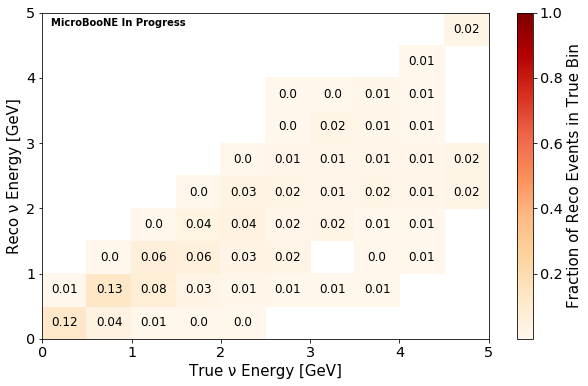

In [54]:
# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, nue, true_var, reco_var, bins, norm=True)

In [55]:
with open('batch_eff_nue_fig_full_500_catsel_nopions_recoE_matrix_trueeff.csv') as file:
    content = file.readlines()
effs = content[0:]
    
for i in range(10):
    effs[i]=effs[i].rstrip().rstrip(',')
    effs[i] = float(effs[i])
    
print(effs)
print("")
#----------------------------------------------------------------------------------

with open('nue_full_500_catsel_nopions_recoE_usingSelection_smearcept.csv') as file:
    content = file.readlines()
smear = content[0:]

for i in range(10):
    smear[i]=smear[i].rstrip().rstrip(',')
    smear[i] = [float(idx) for idx in smear[i].split(', ')]
    
print("Smearcept: ")
print((smear))
print("")
print("")

#------------------------------------------------------------------
#Should be efficiency noramlised by dividing by truth
"""
#print(np.dot(effs, data_signal))
for i in range(10):
    smear[i] = [a*b for a,b in zip(smear[i], effs)]
    
print(smear)
print("")

np.savetxt("nue_full_500_catsel_nopions_recoE_usingSelection_smearcept.csv", 
   smear,
   delimiter =", ", 
   fmt ='% s')
"""
#--------------------------------------------------------

#Now test by multiplying with the prior_true_signal

with open('nue_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal.csv') as file:
    content = file.readlines()
prior_true = content[0:]
    
for i in range(10):
    prior_true[i]=prior_true[i].rstrip().rstrip(',')
    prior_true[i] = float(prior_true[i])
    
print("Prior Truth: ")
print(prior_true)
print("")

made_data_sig = np.dot(smear, prior_true)
print("Recreated Truth: ")
print(made_data_sig)
print("")

for i in made_data_sig:
    print(i)

[0.1282134721770257, 0.17322883622566398, 0.15199404269402614, 0.12330734509643004, 0.11532700948577135, 0.07911392405063292, 0.07065217391304347, 0.07246376811594203, 0.06474820143884892, 0.05084745762711865]

Smearcept: 
[[0.12268141880898145, 0.04043042856254276, 0.008274036074797287, 0.003487894952810833, 0.0004992511233150275, 0.0, 0.0, 0.0, 0.0, 0.0], [0.005532053368044257, 0.12999937799340672, 0.07918252523581003, 0.025235945835043086, 0.011482775836245632, 0.005274261603375527, 0.005434782608695652, 0.007246376811594203, 0.0, 0.0], [0.0, 0.002799029669714499, 0.06304815488995533, 0.05642183011899877, 0.0254618072890664, 0.017932489451476793, 0.0, 0.0036231884057971015, 0.007194244604316547, 0.0], [0.0, 0.0, 0.0014893264934635116, 0.0359048009848174, 0.04343484772840739, 0.015822784810126583, 0.016304347826086956, 0.007246376811594203, 0.007194244604316547, 0.0], [0.0, 0.0, 0.0, 0.0022568732047599507, 0.0309535696455317, 0.023206751054852322, 0.014492753623188406, 0.018115942028

In [ ]:
##------------------------------------------------------------------